# Error modeling

<p style="color:red; font-weight:bold; font-size:400%; margin-bottom:24px">Don't run this notebook right now</p>


**The operations in this notebook can take days to run on a laptop, we will look over the results without running them**

We will run two experiments for error modeling.

1. Bypass experiment
2. Dextran pulse experiment

We will see how to setup a basic error model and how to carry the error from the bypass experiment over to the dextran pulse experiment.

## Load CADETSettings

This imports all the standard libraries, finds CADET and find and creates all the lesson folders.

In [10]:
%run CADETSettings.ipynb

CADET was found. Continue to the next step.


# Create Bypass experiment

For this we will start with Lesson 3 Example 2. This one has an inlet (unit_000) -> CSTR (unit_005) -> DPFR (unit_003) -> Column (unit_001) -> DPFR (unit_004)  -> Outlet (unit_002). We will first load this experiment and then take the column out of the system.

We will also change to 1 component and no-binding.

CompletedProcess(args=['C:/Users/kosh_000/CADET/cadet/bin/cadet-cli.exe', 'C:/Users/kosh_000/CADET/lessons/lesson_9/example_0/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


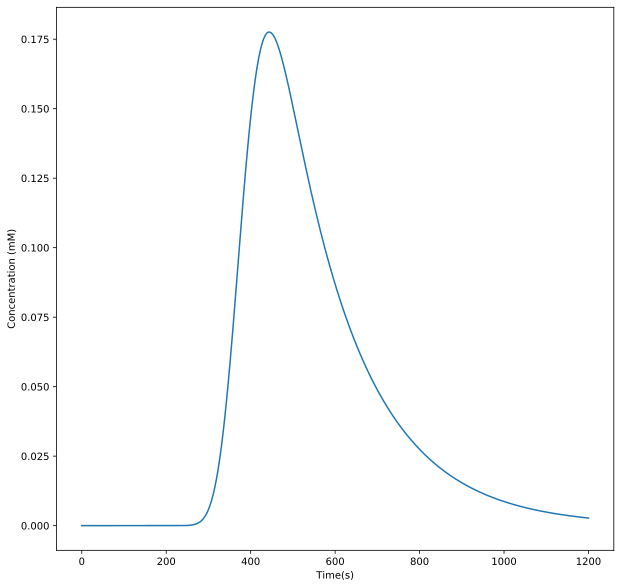

In [2]:
example_dir_0 = lesson_9 / "example_0"
example_dir_0.mkdir(exist_ok = True, parents=True)

example0 = Cadet()

#give a filename for where the simulation should be saved
example0.filename = (lesson_3 / "example_2" / 'example.h5').as_posix()

example0.load()

example0.filename = (example_dir_0 / 'example.h5').as_posix()

#remove the column (we will have to renumber some entries)

del example0.root.input.model.unit_001

#make the cstr unit_001

example0.root.input.model.unit_001 = example0.root.input.model.unit_005
del example0.root.input.model.unit_005

#this connects unit 0 to unit 1 and unit 1 to unit 2 with 2.88e-8 m^3/s with all components
example0.root.input.model.connections.switch_000.connections = [0, 1, -1, -1, 2.88e-8,
                                                             1, 3, -1, -1, 2.88e-8,
                                                             3, 4, -1, -1, 2.88e-8,
                                                             4, 2, -1, -1, 2.88e-8]


#lower components to 1
example0.root.input.model.unit_001.ncomp = 1
example0.root.input.model.unit_002.ncomp = 1
example0.root.input.model.unit_003.ncomp = 1
example0.root.input.model.unit_004.ncomp = 1

example0.root.input.model.unit_003.discretization.nbound = [0,]
example0.root.input.model.unit_004.discretization.nbound = [0,]

#change the inlet to 1 component
#change the inlet
example0.root.input.model.unit_000.ncomp = 1

example0.root.input.model.unit_000.sec_000.const_coeff = [1.0,]
example0.root.input.model.unit_000.sec_000.lin_coeff = [0.0,]
example0.root.input.model.unit_000.sec_000.quad_coeff = [0.0,]
example0.root.input.model.unit_000.sec_000.cube_coeff = [0.0,]

example0.root.input.model.unit_000.sec_001.const_coeff = [0.0,]
example0.root.input.model.unit_000.sec_001.lin_coeff = [0.0,]
example0.root.input.model.unit_000.sec_001.quad_coeff = [0.0,]
example0.root.input.model.unit_000.sec_001.cube_coeff = [0.0,]

del example0.root.input.model.unit_000.sec_002

#change the sections and section times

#solver settings
example0.root.input.solver.sections.section_times = [0.0, 50, 1200]

#set the times that the simulator writes out data for
example0.root.input.solver.user_solution_times = numpy.linspace(0, example0.root.input.solver.sections.section_times[-1], 
                                                               int(example0.root.input.solver.sections.section_times[-1]) + 1)

example0.root.input.solver.sections.nsec = len(example0.root.input.solver.sections.section_times) - 1


#save the simulation
example0.save()

#run the simulation
data = example0.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    example0.load()
    
    #plot the simulation
    plt.figure(figsize=[10,10])
    plt.plot(example0.root.output.solution.solution_times,
        example0.root.output.solution.unit_002.solution_outlet_comp_000)
    plt.xlabel('Time(s)')
    plt.ylabel('Concentration (mM)')
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([example0.root.output.solution.solution_times,
                        example0.root.output.solution.unit_002.solution_outlet_comp_000]).transpose()
    data.to_csv((example_dir_0 / 'example.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

## Create configuration file

For the bypass data we will do error modeling on the dispersion in the tubing along with the volume of the CSTR. 

In [3]:
match0 = Dict()
match0.CADETPath = cadet_path.as_posix()
match0.baseDir = example_dir_0.as_posix()
match0.resultsDir = 'fit_mcmc'
match0.csv = 'fit_results.csv'
match0.checkpointFile = "check"
match0.searchMethod = 'NSGA3'
match0.population = 50
match0.finalGradRefinement = 0
match0.stallGenerations = 10
match0.continueMCMC = 1
match0.tempDir = '/dev/shm'


error_model = Dict()
error_model.file_path = "example.h5"
error_model.experimental_csv = "example.csv"
error_model.name = "main"
error_model.units = [2,]
error_model.delay = [0.0, 3.0]
error_model.flow = [1.0, 0.03]
error_model.load = [1.0, 0.03]
error_model.error_slope = [1.0, 0.001]
error_model.error_base = 50.0
error_model.base = 50.0
error_model.count = 1000

match0.kde_synthetic = [error_model,]

parameter1 = Dict()
parameter1.transform = 'norm_log'
parameter1.component = -1
parameter1.bound = -1
parameter1.location = "/input/model/unit_003/COL_DISPERSION"
parameter1.min = 1e-10
parameter1.max = 1e-4

parameter2 = Dict()
parameter2.transform = 'set_value'
parameter2.componentFrom = -1
parameter2.boundFrom = -1
parameter2.locationFrom = "/input/model/unit_003/COL_DISPERSION"
parameter2.componentTo = -1
parameter2.boundTo = -1
parameter2.locationTo = "/input/model/unit_004/COL_DISPERSION"

parameter3 = Dict()
parameter3.transform = 'norm_log'
parameter3.component = -1
parameter3.bound = -1
parameter3.location = "/input/model/unit_001/INIT_VOLUME"
parameter3.min = 1e-4
parameter3.max = 1e-8

match0.parameters = [parameter1, parameter2, parameter3]

experiment1 = Dict()
experiment1.csv = "example.csv"
experiment1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
experiment1.HDF5 = "example.h5"
experiment1.name = "main"

feature1 = Dict()
feature1.name = "Pulse"
feature1.type = 'ShapeDecay'

experiment1.features = [feature1,]

match0.experiments = [experiment1,]

match_file0 = example_dir_0 / 'example_bypass.json'

with (match_file0).open('w') as json_file:
    json.dump(match0.to_dict(), json_file, indent='\t')

## Run match

Your results are located at /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc 


[2019-10-21 14:44:53,442] launcher  INFO    SCOOP 0.7 1.1 on linux using Python 3.7.3 (default, Mar 27 2019, 22:11:17) [GCC 7.3.0], API: 1013

[2019-10-21 14:44:53,442] launcher  INFO    Deploying 16 worker(s) over 1 host(s).

[2019-10-21 14:44:53,442] launcher  INFO    Worker distribution: 

[2019-10-21 14:44:53,442] launcher  INFO       127.0.0.1:	15 + origin

[2019-10-21 14:44:56,079] util      (b'127.0.0.1:57768') INFO    example.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:44:56,474] match     (b'127.0.0.1:57768') INFO    simulation took 0.39462733268737793

[2019-10-21 14:44:56,508] match     (b'127.0.0.1:57768') INFO    create bias template for experiment main

[2019-10-21 14:44:57,007] gradFD    (b'127.0.0.1:57768') INFO    grad simulation took 0.3859870433807373

[2019-10-21 14:44:57,008] gradFD    (b'127.0.0.1:57768') INFO    grad /home/IBT/heymann/CADET/lessons/lesson_9/example_0/

[2019-10-21 14:47:40,741] launcher  (127.0.0.1:42779) INFO    Root process is done.

[2019-10-21 14:47:40,742] launcher  (127.0.0.1:42779) INFO    Finished cleaning spawned subprocesses.

[2019-10-21 14:47:40,758] match     (b'127.0.0.1:57768') INFO    altFeatures False

[2019-10-21 14:47:40,760] match     (b'127.0.0.1:57768') INFO    altFeatureNames []

[2019-10-21 14:47:40,766] match     (b'127.0.0.1:57768') INFO    lb [0.04548824 0.66470414]  ub [0.62171557 0.99937549]

[2019-10-21 14:47:40,767] match     (b'127.0.0.1:57768') INFO    lb_trans [1.874689869692311e-10, 2.193731257837072e-07]  ub_trans [5.373947152788994e-07, 1.0057685334457832e-08]

[2019-10-21 14:47:40,848] match     (b'127.0.0.1:57768') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/mcmc_refine/example_bypass.json

[2019-10-21 14:47:41,053] util      (b'127.0.0.1:57768') INFO    example.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:41,620] match     (b'127.0.0.1:57768') INFO    simulation 

[2019-10-21 14:47:42,444] util      (b'127.0.0.1:62311') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:42,465] util      (b'127.0.0.1:60760') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:42,484] util      (b'127.0.0.1:58142') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:42,519] util      (b'127.0.0.1:53738') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:42,519] util      (b'127.0.0.1:54599') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:42,519] util      (b'127.0.0.1:57768') INFO    /home/IBT/heymann/CADET/lessons/les

[2019-10-21 14:47:44,453] util      (b'127.0.0.1:59659') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:44,456] util      (b'127.0.0.1:61553') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:44,460] util      (b'127.0.0.1:62311') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:44,490] util      (b'127.0.0.1:56611') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:44,518] util      (b'127.0.0.1:53861') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:44,592] util      (b'127.0.0.1:57549') INFO    /home/IBT/heymann/CADET/lessons/les

[2019-10-21 14:47:46,652] util      (b'127.0.0.1:57549') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:46,680] util      (b'127.0.0.1:54524') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:46,729] util      (b'127.0.0.1:60760') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:46,792] util      (b'127.0.0.1:58142') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:46,836] util      (b'127.0.0.1:57768') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:46,999] util      (b'127.0.0.1:59406') INFO    /home/IBT/heymann/CADET/lessons/les

[2019-10-21 14:47:48,885] util      (b'127.0.0.1:57549') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:48,887] util      (b'127.0.0.1:53586') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:49,025] util      (b'127.0.0.1:61553') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:49,127] util      (b'127.0.0.1:60760') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:49,175] util      (b'127.0.0.1:53861') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:49,194] util      (b'127.0.0.1:57768') INFO    /home/IBT/heymann/CADET/lessons/les

[2019-10-21 14:47:51,351] util      (b'127.0.0.1:62311') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:51,365] util      (b'127.0.0.1:61553') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:51,408] util      (b'127.0.0.1:57768') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:51,432] util      (b'127.0.0.1:60760') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:51,448] util      (b'127.0.0.1:53738') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:51,453] util      (b'127.0.0.1:53861') INFO    /home/IBT/heymann/CADET/lessons/les

[2019-10-21 14:47:53,632] util      (b'127.0.0.1:59406') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:53,686] util      (b'127.0.0.1:57768') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:53,717] util      (b'127.0.0.1:62311') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:53,726] util      (b'127.0.0.1:53738') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:53,773] util      (b'127.0.0.1:60760') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:53,773] util      (b'127.0.0.1:53861') INFO    /home/IBT/heymann/CADET/lessons/les

[2019-10-21 14:47:55,753] util      (b'127.0.0.1:53586') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:55,807] util      (b'127.0.0.1:59406') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:55,833] util      (b'127.0.0.1:53738') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:55,966] util      (b'127.0.0.1:62311') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:56,018] util      (b'127.0.0.1:53861') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:56,032] util      (b'127.0.0.1:60760') INFO    /home/IBT/heymann/CADET/lessons/les

[2019-10-21 14:47:57,893] util      (b'127.0.0.1:53586') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:57,959] util      (b'127.0.0.1:62311') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:58,070] util      (b'127.0.0.1:53861') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:58,076] util      (b'127.0.0.1:59659') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:58,088] util      (b'127.0.0.1:60760') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:47:58,129] util      (b'127.0.0.1:61553') INFO    /home/IBT/heymann/CADET/lessons/les

[2019-10-21 14:48:00,089] util      (b'127.0.0.1:62311') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:00,113] util      (b'127.0.0.1:53738') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:00,209] util      (b'127.0.0.1:59659') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:00,211] util      (b'127.0.0.1:54599') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:00,241] util      (b'127.0.0.1:60760') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:00,255] util      (b'127.0.0.1:54524') INFO    /home/IBT/heymann/CADET/lessons/les

[2019-10-21 14:48:02,295] util      (b'127.0.0.1:53738') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:02,309] util      (b'127.0.0.1:62311') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:02,348] util      (b'127.0.0.1:54524') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:02,362] util      (b'127.0.0.1:59659') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:02,377] util      (b'127.0.0.1:54835') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:02,453] util      (b'127.0.0.1:53586') INFO    /home/IBT/heymann/CADET/lessons/les

[2019-10-21 14:48:04,497] util      (b'127.0.0.1:59659') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:04,508] util      (b'127.0.0.1:62311') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:04,602] util      (b'127.0.0.1:53738') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:04,654] util      (b'127.0.0.1:54599') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:04,763] util      (b'127.0.0.1:61553') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:04,802] util      (b'127.0.0.1:54835') INFO    /home/IBT/heymann/CADET/lessons/les

[2019-10-21 14:48:06,750] util      (b'127.0.0.1:53738') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:06,756] util      (b'127.0.0.1:59659') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:06,852] util      (b'127.0.0.1:53861') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:06,911] util      (b'127.0.0.1:54599') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:06,974] util      (b'127.0.0.1:61553') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:07,008] util      (b'127.0.0.1:58142') INFO    /home/IBT/heymann/CADET/lessons/les

[2019-10-21 14:48:08,613] util      (b'127.0.0.1:59659') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:08,734] util      (b'127.0.0.1:57768') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:08,787] util      (b'127.0.0.1:53861') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:08,831] util      (b'127.0.0.1:56092') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:08,835] util      (b'127.0.0.1:54599') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:08,939] util      (b'127.0.0.1:61553') INFO    /home/IBT/heymann/CADET/lessons/les

[2019-10-21 14:48:10,954] util      (b'127.0.0.1:56092') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:10,985] util      (b'127.0.0.1:60760') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:11,067] util      (b'127.0.0.1:54599') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:11,130] util      (b'127.0.0.1:53861') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:11,187] util      (b'127.0.0.1:57768') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:11,318] util      (b'127.0.0.1:54524') INFO    /home/IBT/heymann/CADET/lessons/les

[2019-10-21 14:48:13,294] util      (b'127.0.0.1:54599') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:13,349] util      (b'127.0.0.1:56092') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:13,377] util      (b'127.0.0.1:62311') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:13,381] util      (b'127.0.0.1:60760') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:13,395] util      (b'127.0.0.1:53738') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:13,397] util      (b'127.0.0.1:59406') INFO    /home/IBT/heymann/CADET/lessons/les

[2019-10-21 14:48:15,469] util      (b'127.0.0.1:54599') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:15,481] util      (b'127.0.0.1:56611') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:15,481] util      (b'127.0.0.1:60760') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:15,500] util      (b'127.0.0.1:57768') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:15,500] util      (b'127.0.0.1:62311') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:15,514] util      (b'127.0.0.1:53738') INFO    /home/IBT/heymann/CADET/lessons/les

[2019-10-21 14:48:17,581] util      (b'127.0.0.1:62311') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:17,603] util      (b'127.0.0.1:59406') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:17,613] util      (b'127.0.0.1:56611') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:17,664] util      (b'127.0.0.1:53586') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:17,722] util      (b'127.0.0.1:54599') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:17,778] util      (b'127.0.0.1:56092') INFO    /home/IBT/heymann/CADET/lessons/les

[2019-10-21 14:48:19,591] util      (b'127.0.0.1:54599') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:19,607] util      (b'127.0.0.1:59406') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:19,637] util      (b'127.0.0.1:56611') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:19,644] util      (b'127.0.0.1:53861') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:19,680] util      (b'127.0.0.1:58142') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:19,734] util      (b'127.0.0.1:53586') INFO    /home/IBT/heymann/CADET/lessons/les

[2019-10-21 14:48:21,808] util      (b'127.0.0.1:56611') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:21,815] util      (b'127.0.0.1:54835') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:21,909] util      (b'127.0.0.1:53861') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:21,920] util      (b'127.0.0.1:61553') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:21,983] util      (b'127.0.0.1:58142') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:22,159] util      (b'127.0.0.1:54524') INFO    /home/IBT/heymann/CADET/lessons/les

[2019-10-21 14:48:24,225] util      (b'127.0.0.1:53861') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:24,311] util      (b'127.0.0.1:61553') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:24,320] util      (b'127.0.0.1:54835') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:24,417] util      (b'127.0.0.1:54524') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:24,423] util      (b'127.0.0.1:58142') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:24,456] util      (b'127.0.0.1:53586') INFO    /home/IBT/heymann/CADET/lessons/les

[2019-10-21 14:48:26,478] util      (b'127.0.0.1:54835') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:26,510] util      (b'127.0.0.1:61553') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:26,602] util      (b'127.0.0.1:59659') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:26,606] util      (b'127.0.0.1:60760') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:26,638] util      (b'127.0.0.1:58142') INFO    /home/IBT/heymann/CADET/lessons/lesson_9/example_0/fit_mcmc/misc/best_main_base.h5 abstol=1.78e-05  reltol=0.0001

[2019-10-21 14:48:26,649] util      (b'127.0.0.1:54524') INFO    /home/IBT/heymann/CADET/lessons/les

[2019-10-21 14:50:25,690] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 22 accept: 0.573 std: 0.0202 mean: 0.541 converge: 40.3

[2019-10-21 14:50:29,999] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 23 accept: 0.57 std: 0.0206 mean: 0.542 converge: 41.2

[2019-10-21 14:50:34,186] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 24 accept: 0.571 std: 0.0209 mean: 0.543 converge: 41.9

[2019-10-21 14:50:38,628] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 25 accept: 0.572 std: 0.0213 mean: 0.544 converge: 42.6

[2019-10-21 14:50:43,086] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 26 accept: 0.57 std: 0.0214 mean: 0.545 converge: 42.9

[2019-10-21 14:50:47,465] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 27 accept: 0.57 std: 0.0215 mean: 0.546 converge: 43.1

[2019-10-21 14:50:52,095] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 28 accept: 0.569 std: 0.0216 mean: 0.547 converge: 43.2

[2019-10-21 14:50:56,466] mcmc      (b'127.0.0.1:57768') INFO    

[2019-10-21 14:54:58,482] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 84 accept: 0.605 std: 0.00932 mean: 0.593 converge: 18.6

[2019-10-21 14:55:02,887] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 85 accept: 0.605 std: 0.00904 mean: 0.593 converge: 18.1

[2019-10-21 14:55:07,384] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 86 accept: 0.605 std: 0.00884 mean: 0.594 converge: 17.7

[2019-10-21 14:55:11,918] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 87 accept: 0.605 std: 0.00867 mean: 0.595 converge: 17.3

[2019-10-21 14:55:16,099] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 88 accept: 0.605 std: 0.00846 mean: 0.595 converge: 16.9

[2019-10-21 14:55:20,622] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 89 accept: 0.605 std: 0.00827 mean: 0.596 converge: 16.5

[2019-10-21 14:55:25,075] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 90 accept: 0.606 std: 0.00804 mean: 0.596 converge: 16.1

[2019-10-21 14:55:29,644] mcmc      (b'127.0.0.1:57768'

[2019-10-21 14:58:57,323] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 145 accept: 0.619 std: 0.00313 mean: 0.614 converge: 6.26

[2019-10-21 14:59:18,746] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 146 accept: 0.619 std: 0.00308 mean: 0.614 converge: 6.15

[2019-10-21 14:59:22,694] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 147 accept: 0.619 std: 0.00301 mean: 0.615 converge: 6.02

[2019-10-21 14:59:26,993] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 148 accept: 0.619 std: 0.00292 mean: 0.615 converge: 5.83

[2019-10-21 14:59:31,599] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 149 accept: 0.619 std: 0.00277 mean: 0.615 converge: 5.55

[2019-10-21 14:59:36,310] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 150 accept: 0.619 std: 0.00265 mean: 0.615 converge: 5.3

[2019-10-21 14:59:40,172] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 151 accept: 0.619 std: 0.00248 mean: 0.615 converge: 4.97

[2019-10-21 14:59:43,772] mcmc      (b'127.0.0.1:

[2019-10-21 15:03:41,670] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 206 accept: 0.623 std: 0.00159 mean: 0.62 converge: 3.17

[2019-10-21 15:03:46,346] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 207 accept: 0.623 std: 0.00161 mean: 0.62 converge: 3.21

[2019-10-21 15:03:50,674] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 208 accept: 0.623 std: 0.00163 mean: 0.62 converge: 3.25

[2019-10-21 15:03:55,327] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 209 accept: 0.623 std: 0.00164 mean: 0.62 converge: 3.29

[2019-10-21 15:03:59,745] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 210 accept: 0.623 std: 0.00166 mean: 0.621 converge: 3.32

[2019-10-21 15:04:04,239] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 211 accept: 0.623 std: 0.00164 mean: 0.621 converge: 3.28

[2019-10-21 15:04:08,610] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 212 accept: 0.623 std: 0.00163 mean: 0.621 converge: 3.26

[2019-10-21 15:04:13,266] mcmc      (b'127.0.0.1:577

[2019-10-21 15:07:47,786] generate_corner_graphs (b'127.0.0.1:62120') INFO    plotting chain

[2019-10-21 15:07:47,921] loggerwriter (b'127.0.0.1:62120') WARNING findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.



[2019-10-21 15:07:47,923] loggerwriter (b'127.0.0.1:62120') WARNING findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.



[2019-10-21 15:07:47,926] loggerwriter (b'127.0.0.1:62120') WARNING findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.



[2019-10-21 15:07:47,928] loggerwriter (b'127.0.0.1:62120') WARNING findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.



[2019-10-21 15:07:47,929] loggerwriter (b'127.0.0.1:62120') WARNING findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.



[2019-10-21 15:07:47,930] loggerwriter (b'127.0.0.1:62120') WARNING findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.



[20

[2019-10-21 15:10:19,040] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 295 accept: 0.631 std: 0.00188 mean: 0.628 converge: 3.75

[2019-10-21 15:10:22,999] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 296 accept: 0.631 std: 0.00184 mean: 0.628 converge: 3.68

[2019-10-21 15:10:28,705] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 297 accept: 0.631 std: 0.00179 mean: 0.628 converge: 3.58

[2019-10-21 15:10:32,341] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 298 accept: 0.631 std: 0.00175 mean: 0.629 converge: 3.51

[2019-10-21 15:10:36,416] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 299 accept: 0.631 std: 0.00171 mean: 0.629 converge: 3.42

[2019-10-21 15:10:41,329] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 300 accept: 0.631 std: 0.00168 mean: 0.629 converge: 3.35

[2019-10-21 15:10:49,315] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 301 accept: 0.631 std: 0.00164 mean: 0.629 converge: 3.28

[2019-10-21 15:10:54,037] mcmc      (b'127.0.0.1

[2019-10-21 15:15:06,108] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 356 accept: 0.635 std: 0.00109 mean: 0.634 converge: 2.19

[2019-10-21 15:15:10,765] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 357 accept: 0.635 std: 0.00106 mean: 0.634 converge: 2.12

[2019-10-21 15:15:15,460] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 358 accept: 0.635 std: 0.00104 mean: 0.634 converge: 2.09

[2019-10-21 15:15:20,156] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 359 accept: 0.635 std: 0.00102 mean: 0.634 converge: 2.03

[2019-10-21 15:15:24,934] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 360 accept: 0.635 std: 0.000994 mean: 0.634 converge: 1.99

[2019-10-21 15:15:28,588] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 361 accept: 0.635 std: 0.000971 mean: 0.634 converge: 1.94

[2019-10-21 15:15:33,186] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 362 accept: 0.635 std: 0.000945 mean: 0.634 converge: 1.89

[2019-10-21 15:15:38,115] mcmc      (b'127.0.

[2019-10-21 15:19:47,733] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 416 accept: 0.636 std: 0.000498 mean: 0.637 converge: 0.996

[2019-10-21 15:19:47,733] mcmc      (b'127.0.0.1:57768') INFO    burn in acceptance is out of tolerance and alpha must be adjusted while burn in continues

[2019-10-21 15:19:47,733] mcmc      (b'127.0.0.1:57768') INFO    previous alpha: 2.0    new alpha: 3.0

[2019-10-21 15:19:52,337] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 417 accept: 0.57 std: 0 mean: 0.57 converge: 0

[2019-10-21 15:19:57,187] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 418 accept: 0.54 std: 0.015 mean: 0.555 converge: 30

[2019-10-21 15:20:01,851] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 419 accept: 0.557 std: 0.0123 mean: 0.556 converge: 24.5

[2019-10-21 15:20:06,507] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 420 accept: 0.562 std: 0.011 mean: 0.557 converge: 22.1

[2019-10-21 15:20:10,710] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 

[2019-10-21 15:24:23,588] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 475 accept: 0.514 std: 0.0112 mean: 0.523 converge: 22.4

[2019-10-21 15:24:28,415] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 476 accept: 0.513 std: 0.0112 mean: 0.523 converge: 22.4

[2019-10-21 15:24:33,181] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 477 accept: 0.513 std: 0.011 mean: 0.522 converge: 22

[2019-10-21 15:24:38,040] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 478 accept: 0.514 std: 0.0106 mean: 0.522 converge: 21.2

[2019-10-21 15:24:42,999] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 479 accept: 0.514 std: 0.0101 mean: 0.521 converge: 20.2

[2019-10-21 15:24:47,276] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 480 accept: 0.514 std: 0.00949 mean: 0.52 converge: 19

[2019-10-21 15:24:52,115] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 481 accept: 0.514 std: 0.00876 mean: 0.52 converge: 17.5

[2019-10-21 15:24:56,784] mcmc      (b'127.0.0.1:57768') INF

[2019-10-21 15:27:57,683] generate_corner_graphs (b'127.0.0.1:65231') INFO    plotting mcmc param 0

[2019-10-21 15:27:57,964] generate_corner_graphs (b'127.0.0.1:65231') INFO    plotting mcmc param 0

[2019-10-21 15:27:58,246] generate_corner_graphs (b'127.0.0.1:65231') INFO    plotting mcmc param 1

[2019-10-21 15:27:58,530] generate_corner_graphs (b'127.0.0.1:65231') INFO    plotting mcmc param 1

[2019-10-21 15:27:59,360] launcher  (127.0.0.1:33081) INFO    Root process is done.

[2019-10-21 15:27:59,361] launcher  (127.0.0.1:33081) INFO    Finished cleaning spawned subprocesses.

[2019-10-21 15:28:03,006] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 525 accept: 0.512 std: 0.00129 mean: 0.515 converge: 2.58

[2019-10-21 15:28:06,571] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 526 accept: 0.512 std: 0.00134 mean: 0.515 converge: 2.67

[2019-10-21 15:28:10,119] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 527 accept: 0.512 std: 0.0014 mean: 0.515 converge: 2.79

[

[2019-10-21 15:31:29,069] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 581 accept: 0.512 std: 0.00108 mean: 0.512 converge: 2.16

[2019-10-21 15:31:32,634] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 582 accept: 0.512 std: 0.00108 mean: 0.512 converge: 2.16

[2019-10-21 15:31:36,455] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 583 accept: 0.512 std: 0.00108 mean: 0.513 converge: 2.16

[2019-10-21 15:31:40,183] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 584 accept: 0.512 std: 0.00107 mean: 0.513 converge: 2.14

[2019-10-21 15:31:43,780] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 585 accept: 0.513 std: 0.00106 mean: 0.513 converge: 2.11

[2019-10-21 15:31:47,453] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 586 accept: 0.512 std: 0.00105 mean: 0.513 converge: 2.11

[2019-10-21 15:31:50,993] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 587 accept: 0.512 std: 0.00106 mean: 0.513 converge: 2.11

[2019-10-21 15:31:54,607] mcmc      (b'127.0.0.1

[2019-10-21 15:35:54,097] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 640 accept: 0.406 std: 0.0167 mean: 0.409 converge: 33.3

[2019-10-21 15:35:58,967] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 641 accept: 0.407 std: 0.0163 mean: 0.409 converge: 32.7

[2019-10-21 15:36:04,144] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 642 accept: 0.405 std: 0.016 mean: 0.409 converge: 32.1

[2019-10-21 15:36:09,227] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 643 accept: 0.407 std: 0.0157 mean: 0.409 converge: 31.5

[2019-10-21 15:36:14,242] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 644 accept: 0.41 std: 0.0155 mean: 0.409 converge: 30.9

[2019-10-21 15:36:19,339] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 645 accept: 0.408 std: 0.0152 mean: 0.409 converge: 30.4

[2019-10-21 15:36:24,274] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 646 accept: 0.407 std: 0.0149 mean: 0.409 converge: 29.9

[2019-10-21 15:36:29,012] mcmc      (b'127.0.0.1:57768') 

[2019-10-21 15:40:48,012] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 701 accept: 0.391 std: 0.00375 mean: 0.397 converge: 7.49

[2019-10-21 15:40:52,954] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 702 accept: 0.391 std: 0.00386 mean: 0.397 converge: 7.71

[2019-10-21 15:40:58,198] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 703 accept: 0.39 std: 0.00399 mean: 0.397 converge: 7.97

[2019-10-21 15:41:03,468] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 704 accept: 0.39 std: 0.00411 mean: 0.397 converge: 8.23

[2019-10-21 15:41:08,377] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 705 accept: 0.39 std: 0.00422 mean: 0.397 converge: 8.44

[2019-10-21 15:41:13,241] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 706 accept: 0.389 std: 0.00434 mean: 0.397 converge: 8.68

[2019-10-21 15:41:18,016] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 707 accept: 0.39 std: 0.00444 mean: 0.396 converge: 8.87

[2019-10-21 15:41:22,824] mcmc      (b'127.0.0.1:577

[2019-10-21 15:45:33,672] generate_graphs (b'127.0.0.1:56597') INFO    graphing directory /home/IBT/heymann/CADET/lessons/lesson_9/example_0

[2019-10-21 15:45:36,513] launcher  (127.0.0.1:46779) INFO    Root process is done.

[2019-10-21 15:45:36,514] launcher  (127.0.0.1:46779) INFO    Finished cleaning spawned subprocesses.

[2019-10-21 15:45:36,559] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 759 accept: 0.392 std: 0.00126 mean: 0.389 converge: 2.52

[2019-10-21 15:45:41,582] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 760 accept: 0.391 std: 0.0013 mean: 0.389 converge: 2.6

[2019-10-21 15:45:46,243] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 761 accept: 0.392 std: 0.00135 mean: 0.389 converge: 2.69

[2019-10-21 15:45:50,981] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 762 accept: 0.391 std: 0.00135 mean: 0.389 converge: 2.7

[2019-10-21 15:45:55,901] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 763 accept: 0.392 std: 0.00135 mean: 0.389 converge:

[2019-10-21 15:48:22,947] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 785 accept: 0.392 std: 0.001 mean: 0.391 converge: 2

[2019-10-21 15:48:27,926] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 786 accept: 0.392 std: 0.001 mean: 0.391 converge: 2.01

[2019-10-21 15:48:32,401] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 787 accept: 0.392 std: 0.000994 mean: 0.391 converge: 1.99

[2019-10-21 15:48:36,358] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 788 accept: 0.392 std: 0.000978 mean: 0.391 converge: 1.96

[2019-10-21 15:48:40,098] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 789 accept: 0.392 std: 0.000962 mean: 0.391 converge: 1.92

[2019-10-21 15:48:44,479] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 790 accept: 0.392 std: 0.000948 mean: 0.391 converge: 1.9

[2019-10-21 15:48:49,332] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 791 accept: 0.392 std: 0.00092 mean: 0.391 converge: 1.84

[2019-10-21 15:48:53,982] mcmc      (b'127.0.0.1:577

[2019-10-21 15:53:16,744] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 846 accept: 0.395 std: 0.000875 mean: 0.393 converge: 1.75

[2019-10-21 15:53:21,877] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 847 accept: 0.395 std: 0.000918 mean: 0.393 converge: 1.84

[2019-10-21 15:53:26,862] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 848 accept: 0.395 std: 0.00095 mean: 0.393 converge: 1.9

[2019-10-21 15:53:31,206] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 849 accept: 0.395 std: 0.000988 mean: 0.393 converge: 1.98

[2019-10-21 15:53:35,242] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 850 accept: 0.395 std: 0.00102 mean: 0.393 converge: 2.04

[2019-10-21 15:53:38,921] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 851 accept: 0.395 std: 0.00107 mean: 0.393 converge: 2.13

[2019-10-21 15:53:42,582] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 852 accept: 0.395 std: 0.00111 mean: 0.393 converge: 2.22

[2019-10-21 15:53:47,186] mcmc      (b'127.0.0

[2019-10-21 15:57:46,108] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 905 accept: 0.358 std: 0.0283 mean: 0.33 converge: 56.6

[2019-10-21 15:57:49,893] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 906 accept: 0.353 std: 0.0274 mean: 0.334 converge: 54.7

[2019-10-21 15:57:53,688] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 907 accept: 0.345 std: 0.0259 mean: 0.335 converge: 51.8

[2019-10-21 15:57:57,266] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 908 accept: 0.338 std: 0.0244 mean: 0.335 converge: 48.8

[2019-10-21 15:58:01,007] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 909 accept: 0.335 std: 0.0232 mean: 0.335 converge: 46.3

[2019-10-21 15:58:04,717] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 910 accept: 0.331 std: 0.0221 mean: 0.335 converge: 44.3

[2019-10-21 15:58:08,388] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 911 accept: 0.343 std: 0.0213 mean: 0.335 converge: 42.6

[2019-10-21 15:58:12,104] mcmc      (b'127.0.0.1:57768')

[2019-10-21 16:01:32,966] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 966 accept: 0.326 std: 0.00367 mean: 0.33 converge: 7.34

[2019-10-21 16:01:36,518] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 967 accept: 0.325 std: 0.00368 mean: 0.329 converge: 7.36

[2019-10-21 16:01:40,098] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 968 accept: 0.325 std: 0.00367 mean: 0.329 converge: 7.34

[2019-10-21 16:01:43,997] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 969 accept: 0.326 std: 0.00366 mean: 0.329 converge: 7.32

[2019-10-21 16:01:47,697] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 970 accept: 0.326 std: 0.00368 mean: 0.329 converge: 7.37

[2019-10-21 16:01:51,542] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 971 accept: 0.325 std: 0.0037 mean: 0.329 converge: 7.4

[2019-10-21 16:01:56,018] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 972 accept: 0.325 std: 0.00369 mean: 0.329 converge: 7.38

[2019-10-21 16:02:01,012] mcmc      (b'127.0.0.1:57

[2019-10-21 16:06:10,043] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1022 accept: 0.329 std: 0.00199 mean: 0.327 converge: 3.97

[2019-10-21 16:06:15,023] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1023 accept: 0.329 std: 0.00199 mean: 0.327 converge: 3.97

[2019-10-21 16:06:20,032] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1024 accept: 0.329 std: 0.00198 mean: 0.327 converge: 3.96

[2019-10-21 16:06:25,222] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1025 accept: 0.328 std: 0.00197 mean: 0.327 converge: 3.93

[2019-10-21 16:06:30,200] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1026 accept: 0.329 std: 0.00196 mean: 0.327 converge: 3.91

[2019-10-21 16:06:34,786] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1027 accept: 0.33 std: 0.00198 mean: 0.327 converge: 3.95

[2019-10-21 16:06:39,495] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1028 accept: 0.329 std: 0.00199 mean: 0.327 converge: 3.98

[2019-10-21 16:06:44,251] mcmc      (b'127

[2019-10-21 16:09:02,183] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1056 accept: 0.328 std: 0.00089 mean: 0.329 converge: 1.78

[2019-10-21 16:09:07,306] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1057 accept: 0.328 std: 0.000907 mean: 0.329 converge: 1.81

[2019-10-21 16:09:12,273] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1058 accept: 0.328 std: 0.000919 mean: 0.329 converge: 1.84

[2019-10-21 16:09:17,300] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1059 accept: 0.328 std: 0.000929 mean: 0.329 converge: 1.86

[2019-10-21 16:09:22,394] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1060 accept: 0.328 std: 0.000933 mean: 0.329 converge: 1.87

[2019-10-21 16:09:27,609] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1061 accept: 0.328 std: 0.000929 mean: 0.329 converge: 1.86

[2019-10-21 16:09:32,683] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1062 accept: 0.329 std: 0.00091 mean: 0.329 converge: 1.82

[2019-10-21 16:09:37,393] mcmc      

[2019-10-21 16:13:50,388] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1116 accept: 0.33 std: 0.000579 mean: 0.33 converge: 1.16

[2019-10-21 16:13:55,561] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1117 accept: 0.331 std: 0.000597 mean: 0.33 converge: 1.19

[2019-10-21 16:14:00,576] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1118 accept: 0.33 std: 0.000595 mean: 0.33 converge: 1.19

[2019-10-21 16:14:05,385] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1119 accept: 0.33 std: 0.000583 mean: 0.33 converge: 1.17

[2019-10-21 16:14:10,463] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1120 accept: 0.33 std: 0.000559 mean: 0.33 converge: 1.12

[2019-10-21 16:14:15,291] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1121 accept: 0.331 std: 0.000545 mean: 0.33 converge: 1.09

[2019-10-21 16:14:20,328] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1122 accept: 0.331 std: 0.000531 mean: 0.33 converge: 1.06

[2019-10-21 16:14:25,499] mcmc      (b'127.0.

[2019-10-21 16:18:36,553] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1175 accept: 0.276 std: 0.0123 mean: 0.261 converge: 24.5

[2019-10-21 16:18:40,362] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1176 accept: 0.276 std: 0.0123 mean: 0.261 converge: 24.7

[2019-10-21 16:18:44,092] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1177 accept: 0.278 std: 0.0124 mean: 0.261 converge: 24.9

[2019-10-21 16:18:47,823] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1178 accept: 0.276 std: 0.0125 mean: 0.262 converge: 25

[2019-10-21 16:18:51,534] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1179 accept: 0.277 std: 0.0111 mean: 0.263 converge: 22.3

[2019-10-21 16:18:55,095] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1180 accept: 0.277 std: 0.0095 mean: 0.264 converge: 19

[2019-10-21 16:18:58,867] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1181 accept: 0.277 std: 0.00804 mean: 0.265 converge: 16.1

[2019-10-21 16:19:02,875] mcmc      (b'127.0.0.1:57

[2019-10-21 16:23:11,016] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1236 accept: 0.279 std: 0.00107 mean: 0.279 converge: 2.15

[2019-10-21 16:23:14,623] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1237 accept: 0.279 std: 0.00105 mean: 0.279 converge: 2.1

[2019-10-21 16:23:18,169] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1238 accept: 0.279 std: 0.00104 mean: 0.279 converge: 2.08

[2019-10-21 16:23:21,822] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1239 accept: 0.28 std: 0.00104 mean: 0.279 converge: 2.09

[2019-10-21 16:23:25,388] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1240 accept: 0.28 std: 0.00103 mean: 0.279 converge: 2.06

[2019-10-21 16:23:29,055] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1241 accept: 0.28 std: 0.00103 mean: 0.279 converge: 2.07

[2019-10-21 16:23:32,828] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1242 accept: 0.279 std: 0.00103 mean: 0.279 converge: 2.07

[2019-10-21 16:23:36,693] mcmc      (b'127.0.

[2019-10-21 16:26:41,952] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1291 accept: 0.282 std: 0.00104 mean: 0.281 converge: 2.08

[2019-10-21 16:26:45,565] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1292 accept: 0.283 std: 0.00103 mean: 0.281 converge: 2.07

[2019-10-21 16:26:49,439] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1293 accept: 0.283 std: 0.00105 mean: 0.281 converge: 2.09

[2019-10-21 16:26:53,236] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1294 accept: 0.283 std: 0.00104 mean: 0.281 converge: 2.09

[2019-10-21 16:26:57,143] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1295 accept: 0.283 std: 0.00105 mean: 0.281 converge: 2.09

[2019-10-21 16:27:00,750] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1296 accept: 0.283 std: 0.00103 mean: 0.281 converge: 2.06

[2019-10-21 16:27:04,375] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1297 accept: 0.283 std: 0.00105 mean: 0.281 converge: 2.1

[2019-10-21 16:27:08,422] mcmc      (b'127

[2019-10-21 16:29:31,377] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1325 accept: 0.282 std: 0.000562 mean: 0.283 converge: 1.12

[2019-10-21 16:29:36,437] mcmc      (b'127.0.0.1:57768') INFO    burn:  idx: 1326 accept: 0.282 std: 0.000494 mean: 0.283 converge: 0.989

[2019-10-21 16:29:36,437] mcmc      (b'127.0.0.1:57768') INFO    burn in completed at iteration 1327

[2019-10-21 16:29:46,056] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 0 accept: 0.250

[2019-10-21 16:29:51,156] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 1 accept: 0.290

[2019-10-21 16:29:56,309] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 2 accept: 0.293

[2019-10-21 16:30:01,741] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 3 accept: 0.280

[2019-10-21 16:30:06,693] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 4 accept: 0.276

[2019-10-21 16:30:11,003] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 5 accept: 0.265

[2019-10-21 16:30:14,753] mcmc      (b'127.0.0.1:57768') INFO  

[2019-10-21 16:35:47,255] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 75 accept: 0.287

[2019-10-21 16:35:52,133] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 76 accept: 0.287

[2019-10-21 16:35:56,841] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 77 accept: 0.287

[2019-10-21 16:36:01,784] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 78 accept: 0.287

[2019-10-21 16:36:06,507] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 79 accept: 0.288

[2019-10-21 16:36:11,435] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 80 accept: 0.287

[2019-10-21 16:36:16,251] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 81 accept: 0.288

[2019-10-21 16:36:21,467] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 82 accept: 0.288

[2019-10-21 16:36:26,497] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 83 accept: 0.288

[2019-10-21 16:36:31,578] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 84 accept: 0.288

[2019-10-21 16:36:36,603] mcmc      (b'127.0.0.1:57768') INF

[2019-10-21 16:41:27,730] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 150 accept: 0.290

[2019-10-21 16:41:32,598] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 151 accept: 0.289

[2019-10-21 16:41:37,429] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 152 accept: 0.289

[2019-10-21 16:41:42,196] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 153 accept: 0.289

[2019-10-21 16:41:47,264] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 154 accept: 0.289

[2019-10-21 16:41:52,002] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 155 accept: 0.289

[2019-10-21 16:41:56,867] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 156 accept: 0.289

[2019-10-21 16:42:01,617] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 157 accept: 0.289

[2019-10-21 16:42:06,435] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 158 accept: 0.289

[2019-10-21 16:42:11,250] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 159 accept: 0.289

[2019-10-21 16:42:16,080] mcmc      (b'127.0.0.1:5

[2019-10-21 16:47:16,071] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 221 accept: 0.289

[2019-10-21 16:47:21,010] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 222 accept: 0.290

[2019-10-21 16:47:25,440] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 223 accept: 0.289

[2019-10-21 16:47:29,221] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 224 accept: 0.289

[2019-10-21 16:47:29,234] mcmc      (b'127.0.0.1:57768') INFO    The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!

N/50 = 4;

tau: [13.12987534 12.78998574]

[2019-10-21 16:47:29,234] mcmc      (b'127.0.0.1:57768') INFO    Mean acceptance fraction: 225 0.289 tau: [13.12987534 12.78998574]

[2019-10-21 16:47:33,106] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 225 accept: 0.289

[2019-10-21 16:47:36,639] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 226 accept: 0.290

[2019-10-21 16:47:40,297] mcmc      (b'127

[2019-10-21 16:49:34,601] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 243 accept: 0.289

[2019-10-21 16:49:38,391] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 244 accept: 0.289

[2019-10-21 16:49:42,306] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 245 accept: 0.289

[2019-10-21 16:49:45,901] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 246 accept: 0.289

[2019-10-21 16:49:49,528] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 247 accept: 0.289

[2019-10-21 16:49:53,124] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 248 accept: 0.289

[2019-10-21 16:49:56,775] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 249 accept: 0.289

[2019-10-21 16:49:56,788] mcmc      (b'127.0.0.1:57768') INFO    The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!

N/50 = 5;

tau: [14.51009894 13.68088975]

[2019-10-21 16:49:56,788] mcmc      (b'127.0.0.1:57768') INFO    Mean acceptance

[2019-10-21 16:54:30,753] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 317 accept: 0.288

[2019-10-21 16:54:34,373] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 318 accept: 0.288

[2019-10-21 16:54:38,171] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 319 accept: 0.287

[2019-10-21 16:54:43,082] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 320 accept: 0.287

[2019-10-21 16:54:48,089] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 321 accept: 0.287

[2019-10-21 16:54:53,096] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 322 accept: 0.287

[2019-10-21 16:54:57,998] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 323 accept: 0.287

[2019-10-21 16:55:03,104] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 324 accept: 0.287

[2019-10-21 16:55:03,123] mcmc      (b'127.0.0.1:57768') INFO    The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!

N/50 = 6;

tau: [16.45673905

[2019-10-21 16:59:53,509] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 391 accept: 0.285

[2019-10-21 16:59:57,087] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 392 accept: 0.285

[2019-10-21 17:00:00,680] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 393 accept: 0.285

[2019-10-21 17:00:04,392] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 394 accept: 0.285

[2019-10-21 17:00:08,176] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 395 accept: 0.284

[2019-10-21 17:00:11,811] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 396 accept: 0.285

[2019-10-21 17:00:15,653] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 397 accept: 0.285

[2019-10-21 17:00:19,280] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 398 accept: 0.285

[2019-10-21 17:00:22,916] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 399 accept: 0.285

[2019-10-21 17:00:22,932] mcmc      (b'127.0.0.1:57768') INFO    The chain is shorter than 50 times the integrated autocorrelation time for 2 par

[2019-10-21 17:04:26,259] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 465 accept: 0.283

[2019-10-21 17:04:29,856] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 466 accept: 0.284

[2019-10-21 17:04:33,581] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 467 accept: 0.283

[2019-10-21 17:04:37,209] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 468 accept: 0.284

[2019-10-21 17:04:40,778] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 469 accept: 0.284

[2019-10-21 17:04:44,459] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 470 accept: 0.284

[2019-10-21 17:04:48,311] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 471 accept: 0.284

[2019-10-21 17:04:51,945] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 472 accept: 0.284

[2019-10-21 17:04:55,586] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 473 accept: 0.284

[2019-10-21 17:04:59,255] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 474 accept: 0.284

[2019-10-21 17:04:59,270] mcmc      (b'127.0.0.1:5

[2019-10-21 17:08:40,282] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 532 accept: 0.284

[2019-10-21 17:08:43,859] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 533 accept: 0.284

[2019-10-21 17:08:44,161] launcher  INFO    SCOOP 0.7 1.1 on linux using Python 3.7.3 (default, Mar 27 2019, 22:11:17) [GCC 7.3.0], API: 1013

[2019-10-21 17:08:44,161] launcher  INFO    Deploying 1 worker(s) over 1 host(s).

[2019-10-21 17:08:44,161] launcher  INFO    Worker distribution: 

[2019-10-21 17:08:44,161] launcher  INFO       127.0.0.1:	0 + origin

[2019-10-21 17:08:51,746] generate_corner_graphs (b'127.0.0.1:56024') INFO    graphing directory /home/IBT/heymann/CADET/lessons/lesson_9/example_0

[2019-10-21 17:08:51,746] generate_corner_graphs (b'127.0.0.1:56024') INFO    plotting corner plots

[2019-10-21 17:08:51,768] generate_corner_graphs (b'127.0.0.1:56024') INFO    plotting tau plots

[2019-10-21 17:08:52,104] generate_corner_graphs (b'127.0.0.1:56024') INFO    plot flat chain

[201

[2019-10-21 17:11:05,119] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 568 accept: 0.284

[2019-10-21 17:11:08,691] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 569 accept: 0.284

[2019-10-21 17:11:12,301] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 570 accept: 0.284

[2019-10-21 17:11:15,965] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 571 accept: 0.284

[2019-10-21 17:11:19,546] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 572 accept: 0.284

[2019-10-21 17:11:23,237] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 573 accept: 0.283

[2019-10-21 17:11:26,808] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 574 accept: 0.283

[2019-10-21 17:11:26,831] mcmc      (b'127.0.0.1:57768') INFO    The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!

N/50 = 12;

tau: [17.97507343 17.57503787]

[2019-10-21 17:11:26,831] mcmc      (b'127.0.0.1:57768') INFO    Mean acceptanc

[2019-10-21 17:15:31,914] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 642 accept: 0.284

[2019-10-21 17:15:35,497] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 643 accept: 0.284

[2019-10-21 17:15:39,022] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 644 accept: 0.284

[2019-10-21 17:15:42,575] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 645 accept: 0.284

[2019-10-21 17:15:46,177] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 646 accept: 0.284

[2019-10-21 17:15:49,777] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 647 accept: 0.283

[2019-10-21 17:15:53,584] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 648 accept: 0.283

[2019-10-21 17:15:57,216] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 649 accept: 0.283

[2019-10-21 17:15:57,239] mcmc      (b'127.0.0.1:57768') INFO    The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!

N/50 = 13;

tau: [18.4989532

[2019-10-21 17:20:00,645] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 716 accept: 0.284

[2019-10-21 17:20:04,482] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 717 accept: 0.284

[2019-10-21 17:20:08,075] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 718 accept: 0.284

[2019-10-21 17:20:11,704] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 719 accept: 0.284

[2019-10-21 17:20:15,375] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 720 accept: 0.284

[2019-10-21 17:20:18,890] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 721 accept: 0.284

[2019-10-21 17:20:22,473] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 722 accept: 0.284

[2019-10-21 17:20:26,001] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 723 accept: 0.284

[2019-10-21 17:20:29,677] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 724 accept: 0.284

[2019-10-21 17:20:29,700] mcmc      (b'127.0.0.1:57768') INFO    The chain is shorter than 50 times the integrated autocorrelation time for 2 par

[2019-10-21 17:24:29,023] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 790 accept: 0.283

[2019-10-21 17:24:34,487] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 791 accept: 0.283

[2019-10-21 17:24:38,053] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 792 accept: 0.283

[2019-10-21 17:24:41,766] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 793 accept: 0.283

[2019-10-21 17:24:45,325] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 794 accept: 0.284

[2019-10-21 17:24:48,907] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 795 accept: 0.284

[2019-10-21 17:24:52,451] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 796 accept: 0.284

[2019-10-21 17:24:56,055] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 797 accept: 0.284

[2019-10-21 17:24:59,593] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 798 accept: 0.284

[2019-10-21 17:25:03,302] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 799 accept: 0.284

[2019-10-21 17:25:03,325] mcmc      (b'127.0.0.1:5

[2019-10-21 17:28:39,768] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 857 accept: 0.283

[2019-10-21 17:28:43,408] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 858 accept: 0.283

[2019-10-21 17:28:47,131] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 859 accept: 0.283

[2019-10-21 17:28:50,770] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 860 accept: 0.283

[2019-10-21 17:28:54,329] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 861 accept: 0.283

[2019-10-21 17:28:57,933] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 862 accept: 0.283

[2019-10-21 17:28:58,231] launcher  INFO    SCOOP 0.7 1.1 on linux using Python 3.7.3 (default, Mar 27 2019, 22:11:17) [GCC 7.3.0], API: 1013

[2019-10-21 17:28:58,231] launcher  INFO    Deploying 1 worker(s) over 1 host(s).

[2019-10-21 17:28:58,232] launcher  INFO    Worker distribution: 

[2019-10-21 17:28:58,232] launcher  INFO       127.0.0.1:	0 + origin

[2019-10-21 17:29:05,313] generate_corner_graphs (b'127.0.0.1:54071

[2019-10-21 17:36:39,475] loggerwriter (b'127.0.0.1:55003') INFO    differential_evolution step 5: f(x)= 0.499916

[2019-10-21 17:36:39,546] loggerwriter (b'127.0.0.1:55003') INFO    differential_evolution step 6: f(x)= 0.499916

[2019-10-21 17:36:39,617] loggerwriter (b'127.0.0.1:55003') INFO    differential_evolution step 7: f(x)= 0.499916

[2019-10-21 17:36:39,689] loggerwriter (b'127.0.0.1:55003') INFO    differential_evolution step 8: f(x)= 0.499916

[2019-10-21 17:36:39,760] loggerwriter (b'127.0.0.1:55003') INFO    differential_evolution step 9: f(x)= 0.499916

[2019-10-21 17:36:39,831] loggerwriter (b'127.0.0.1:55003') INFO    differential_evolution step 10: f(x)= 0.393569

[2019-10-21 17:36:39,903] loggerwriter (b'127.0.0.1:55003') INFO    differential_evolution step 11: f(x)= 0.393569

[2019-10-21 17:36:39,974] loggerwriter (b'127.0.0.1:55003') INFO    differential_evolution step 12: f(x)= 0.393569

[2019-10-21 17:36:40,046] loggerwriter (b'127.0.0.1:55003') INFO    different

[2019-10-21 17:36:44,590] loggerwriter (b'127.0.0.1:55003') INFO    differential_evolution step 78: f(x)= 0.225758

[2019-10-21 17:36:44,655] loggerwriter (b'127.0.0.1:55003') INFO    differential_evolution step 79: f(x)= 0.216562

[2019-10-21 17:36:44,720] loggerwriter (b'127.0.0.1:55003') INFO    differential_evolution step 80: f(x)= 0.216562

[2019-10-21 17:36:44,784] loggerwriter (b'127.0.0.1:55003') INFO    differential_evolution step 81: f(x)= 0.21474

[2019-10-21 17:36:44,850] loggerwriter (b'127.0.0.1:55003') INFO    differential_evolution step 82: f(x)= 0.21474

[2019-10-21 17:36:44,915] loggerwriter (b'127.0.0.1:55003') INFO    differential_evolution step 83: f(x)= 0.214153

[2019-10-21 17:36:44,980] loggerwriter (b'127.0.0.1:55003') INFO    differential_evolution step 84: f(x)= 0.214153

[2019-10-21 17:36:45,045] loggerwriter (b'127.0.0.1:55003') INFO    differential_evolution step 85: f(x)= 0.213522

[2019-10-21 17:36:45,110] loggerwriter (b'127.0.0.1:55003') INFO    differ

[2019-10-21 17:39:45,068] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 920 accept: 0.283

[2019-10-21 17:39:48,801] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 921 accept: 0.283

[2019-10-21 17:39:52,799] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 922 accept: 0.283

[2019-10-21 17:39:56,341] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 923 accept: 0.283

[2019-10-21 17:39:59,933] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 924 accept: 0.283

[2019-10-21 17:39:59,956] mcmc      (b'127.0.0.1:57768') INFO    The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!

N/50 = 18;

tau: [19.93843414 20.03760461]

[2019-10-21 17:39:59,956] mcmc      (b'127.0.0.1:57768') INFO    Mean acceptance fraction: 925 0.283 tau: [19.93843414 20.03760461]

[2019-10-21 17:40:03,715] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 925 accept: 0.283

[2019-10-21 17:40:07,298] mcmc      (b'12

[2019-10-21 17:44:13,646] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 994 accept: 0.282

[2019-10-21 17:44:17,205] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 995 accept: 0.282

[2019-10-21 17:44:20,810] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 996 accept: 0.282

[2019-10-21 17:44:24,532] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 997 accept: 0.282

[2019-10-21 17:44:28,025] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 998 accept: 0.282

[2019-10-21 17:44:31,695] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 999 accept: 0.282

[2019-10-21 17:44:31,718] mcmc      (b'127.0.0.1:57768') INFO    The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!

N/50 = 20;

tau: [20.54166075 20.78381   ]

[2019-10-21 17:44:31,718] mcmc      (b'127.0.0.1:57768') INFO    Mean acceptance fraction: 1000 0.282 tau: [20.54166075 20.78381   ]

[2019-10-21 17:44:35,206] mcmc      (b'1

[2019-10-21 17:48:19,752] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 1060 accept: 0.282

[2019-10-21 17:48:23,318] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 1061 accept: 0.282

[2019-10-21 17:48:26,939] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 1062 accept: 0.282

[2019-10-21 17:48:30,472] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 1063 accept: 0.282

[2019-10-21 17:48:34,016] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 1064 accept: 0.282

[2019-10-21 17:48:36,106] launcher  INFO    SCOOP 0.7 1.1 on linux using Python 3.7.3 (default, Mar 27 2019, 22:11:17) [GCC 7.3.0], API: 1013

[2019-10-21 17:48:36,106] launcher  INFO    Deploying 4 worker(s) over 1 host(s).

[2019-10-21 17:48:36,106] launcher  INFO    Worker distribution: 

[2019-10-21 17:48:36,106] launcher  INFO       127.0.0.1:	3 + origin

[2019-10-21 17:48:39,311] generate_graphs (b'127.0.0.1:61025') INFO    graphing directory /home/IBT/heymann/CADET/lessons/lesson_9/example_0

generate_graphs

[2019-10-21 17:50:54,254] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 1081 accept: 0.283

[2019-10-21 17:50:57,764] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 1082 accept: 0.282

[2019-10-21 17:51:01,355] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 1083 accept: 0.283

[2019-10-21 17:51:04,974] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 1084 accept: 0.283

[2019-10-21 17:51:08,613] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 1085 accept: 0.283

[2019-10-21 17:51:12,078] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 1086 accept: 0.283

[2019-10-21 17:51:15,685] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 1087 accept: 0.283

[2019-10-21 17:51:19,268] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 1088 accept: 0.283

[2019-10-21 17:51:22,999] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 1089 accept: 0.283

[2019-10-21 17:51:26,659] mcmc      (b'127.0.0.1:57768') INFO    run:  idx: 1090 accept: 0.283

[2019-10-21 17:51:30,212] mcmc      (b'1

[2019-10-21 18:04:27,193] loggerwriter (b'127.0.0.1:54544') INFO    differential_evolution step 33: f(x)= 0.623868

[2019-10-21 18:04:27,257] loggerwriter (b'127.0.0.1:54544') INFO    differential_evolution step 34: f(x)= 0.623868

[2019-10-21 18:04:27,320] loggerwriter (b'127.0.0.1:54544') INFO    differential_evolution step 35: f(x)= 0.499348

[2019-10-21 18:04:27,383] loggerwriter (b'127.0.0.1:54544') INFO    differential_evolution step 36: f(x)= 0.499348

[2019-10-21 18:04:27,446] loggerwriter (b'127.0.0.1:54544') INFO    differential_evolution step 37: f(x)= 0.499348

[2019-10-21 18:04:27,510] loggerwriter (b'127.0.0.1:54544') INFO    differential_evolution step 38: f(x)= 0.499348

[2019-10-21 18:04:27,573] loggerwriter (b'127.0.0.1:54544') INFO    differential_evolution step 39: f(x)= 0.499348

[2019-10-21 18:04:27,641] loggerwriter (b'127.0.0.1:54544') INFO    differential_evolution step 40: f(x)= 0.499348

[2019-10-21 18:04:27,707] loggerwriter (b'127.0.0.1:54544') INFO    diff

[2019-10-21 18:04:41,781] generate_corner_graphs (b'127.0.0.1:59983') INFO    plotting chain

[2019-10-21 18:04:42,973] generate_corner_graphs (b'127.0.0.1:59983') INFO    plotting mcmc param 0

[2019-10-21 18:04:43,250] generate_corner_graphs (b'127.0.0.1:59983') INFO    plotting mcmc param 0

[2019-10-21 18:04:43,522] generate_corner_graphs (b'127.0.0.1:59983') INFO    plotting mcmc param 0

[2019-10-21 18:04:43,810] generate_corner_graphs (b'127.0.0.1:59983') INFO    plotting mcmc param 0

[2019-10-21 18:04:44,099] generate_corner_graphs (b'127.0.0.1:59983') INFO    plotting mcmc param 1

[2019-10-21 18:04:44,375] generate_corner_graphs (b'127.0.0.1:59983') INFO    plotting mcmc param 1

[2019-10-21 18:04:44,654] generate_corner_graphs (b'127.0.0.1:59983') INFO    plotting mcmc param 1

[2019-10-21 18:04:44,942] generate_corner_graphs (b'127.0.0.1:59983') INFO    plotting mcmc param 1

[2019-10-21 18:04:45,818] launcher  (127.0.0.1:37171) INFO    Root process is done.

[2019-10-21 1

Time                              Name Method  \
0  Mon Oct 21 14:46:11 2019  e64380160db97528d6a89c27a305d248    EVO   

   Condition Number  COL_DISPERSION Comp:-1 Bound:-1  \
0               NaN                         0.000021   

   INIT_VOLUME Comp:-1 Bound:-1  main_Pulse_Similarity  main_Pulse_Value  \
0                      0.000005               0.999988          0.992249   

   main_Pulse_Time  main_Pulse_Derivative_Similarity  \
0         0.997065                          0.999977   

   main_Pulse_Der_High_Value  main_Pulse_Der_Low_Value  Product Root Score  \
0                   0.998718                  0.982555            0.995073   

   Min Score  Mean Score       SSE  
0   0.982555    0.995092  0.001978

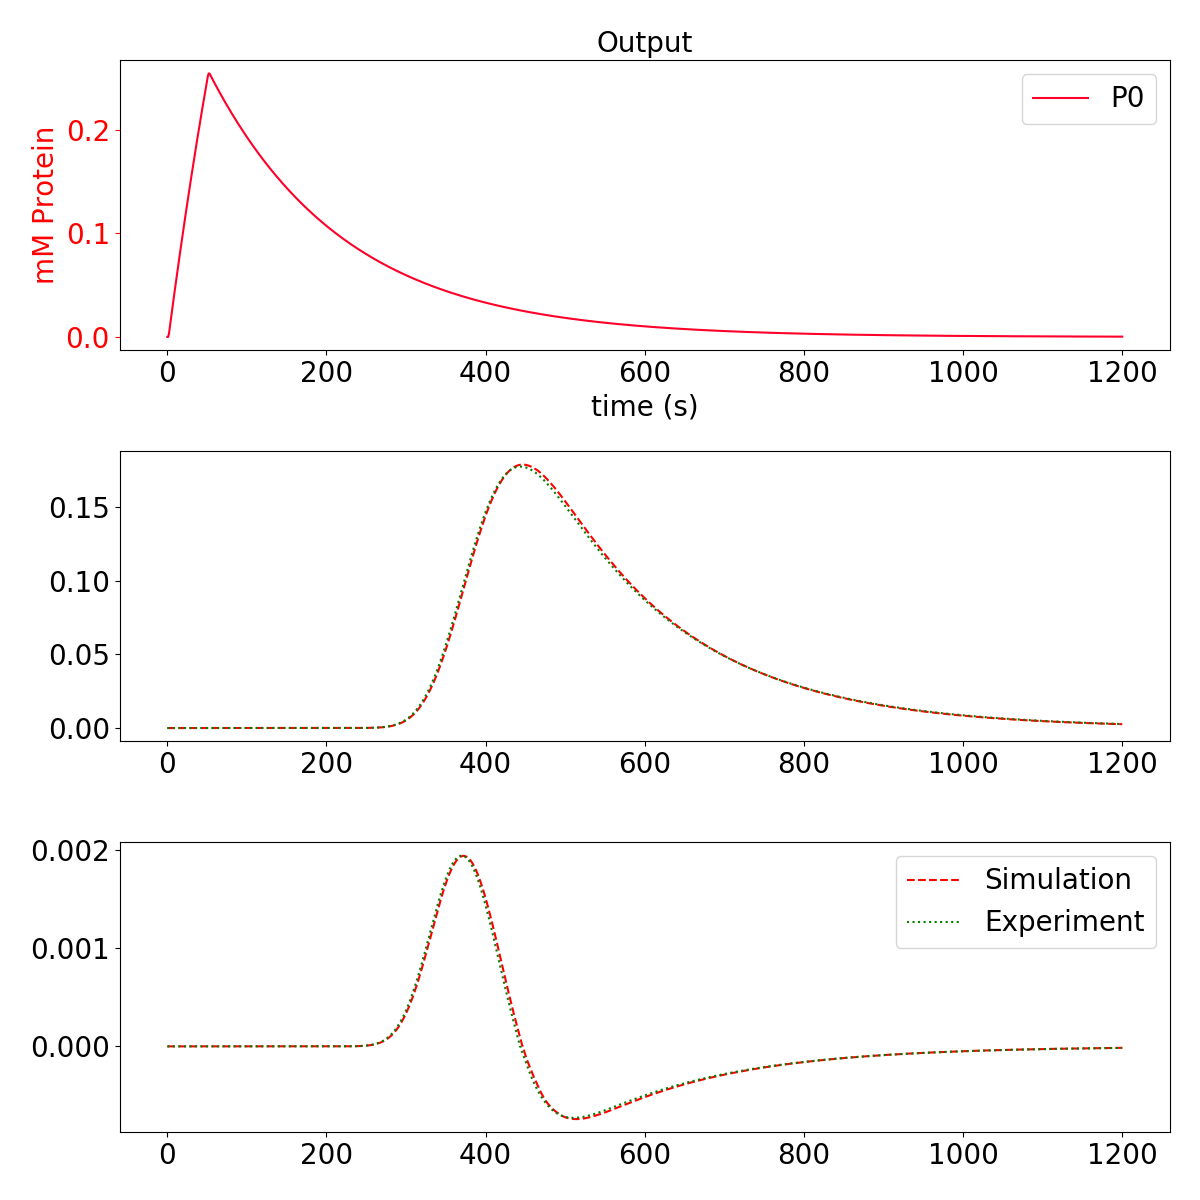

Method: Product Root Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.06e-05  true_value = 2.00e-05 error: 3%
INIT_VOLUME Comp:-1 Bound:-1 = 4.90e-06  true_value = 5.00e-06 error: 2%


Method: Min Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.06e-05  true_value = 2.00e-05 error: 3%
INIT_VOLUME Comp:-1 Bound:-1 = 4.90e-06  true_value = 5.00e-06 error: 2%


Method: Mean Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.06e-05  true_value = 2.00e-05 error: 3%
INIT_VOLUME Comp:-1 Bound:-1 = 4.90e-06  true_value = 5.00e-06 error: 2%


Method: SSE
COL_DISPERSION Comp:-1 Bound:-1 = 2.06e-05  true_value = 2.00e-05 error: 3%
INIT_VOLUME Comp:-1 Bound:-1 = 4.90e-06  true_value = 5.00e-06 error: 2%




In [4]:
true_values0 = numpy.array([example0.root.input.model.unit_003.col_dispersion, 
                           example0.root.input.model.unit_001.init_volume,])
    
sim0 = run_match(match0,
                    match_file0,
                    true_values0,
                    delete=True)

## View results

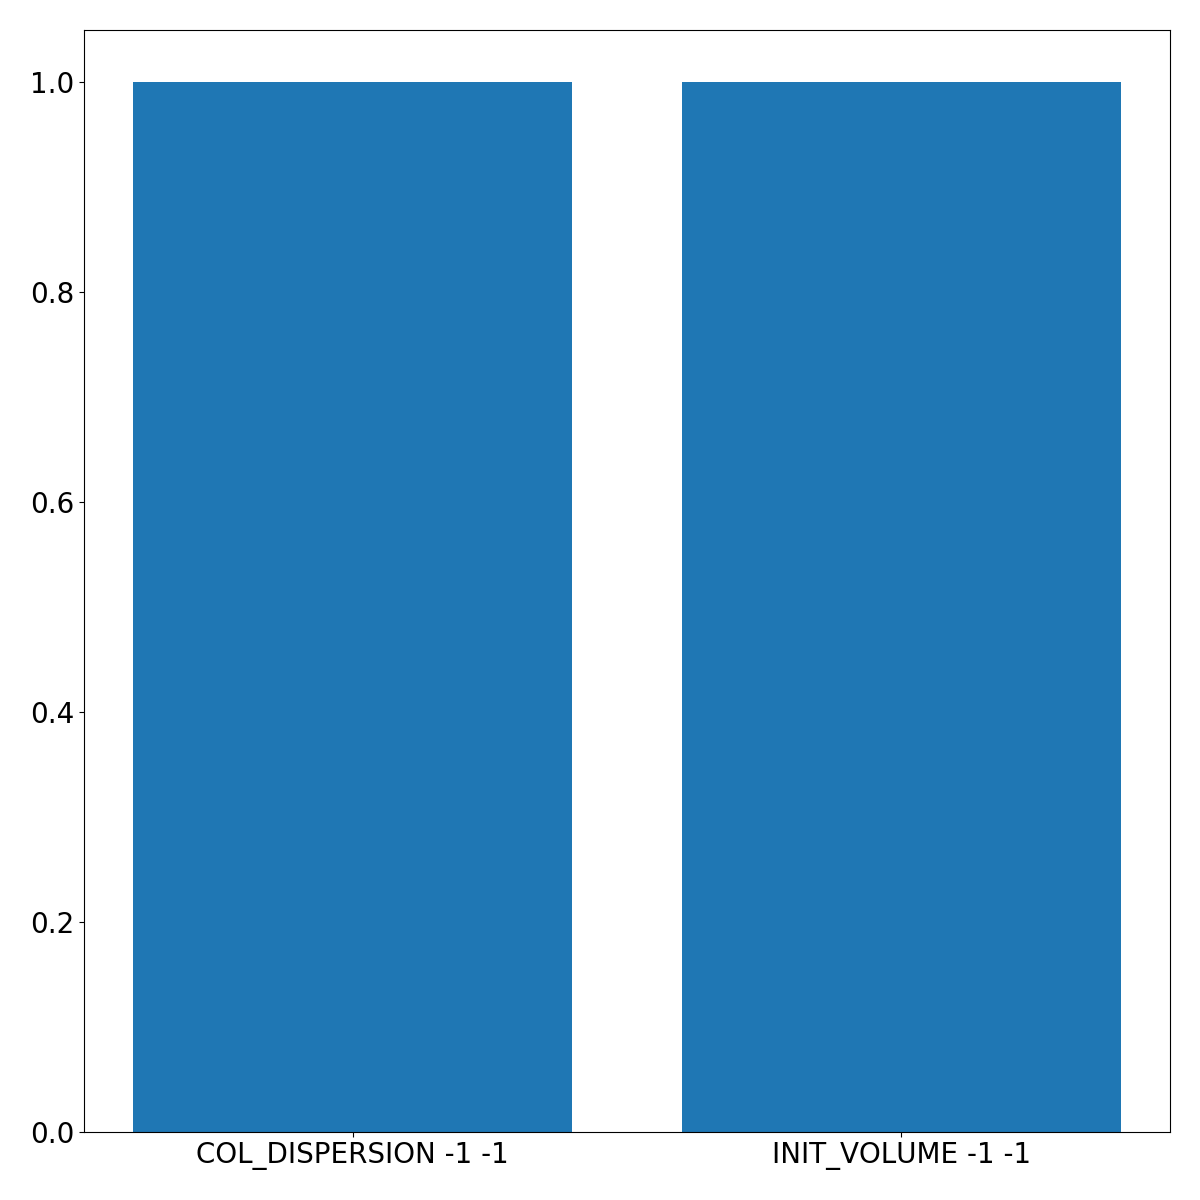

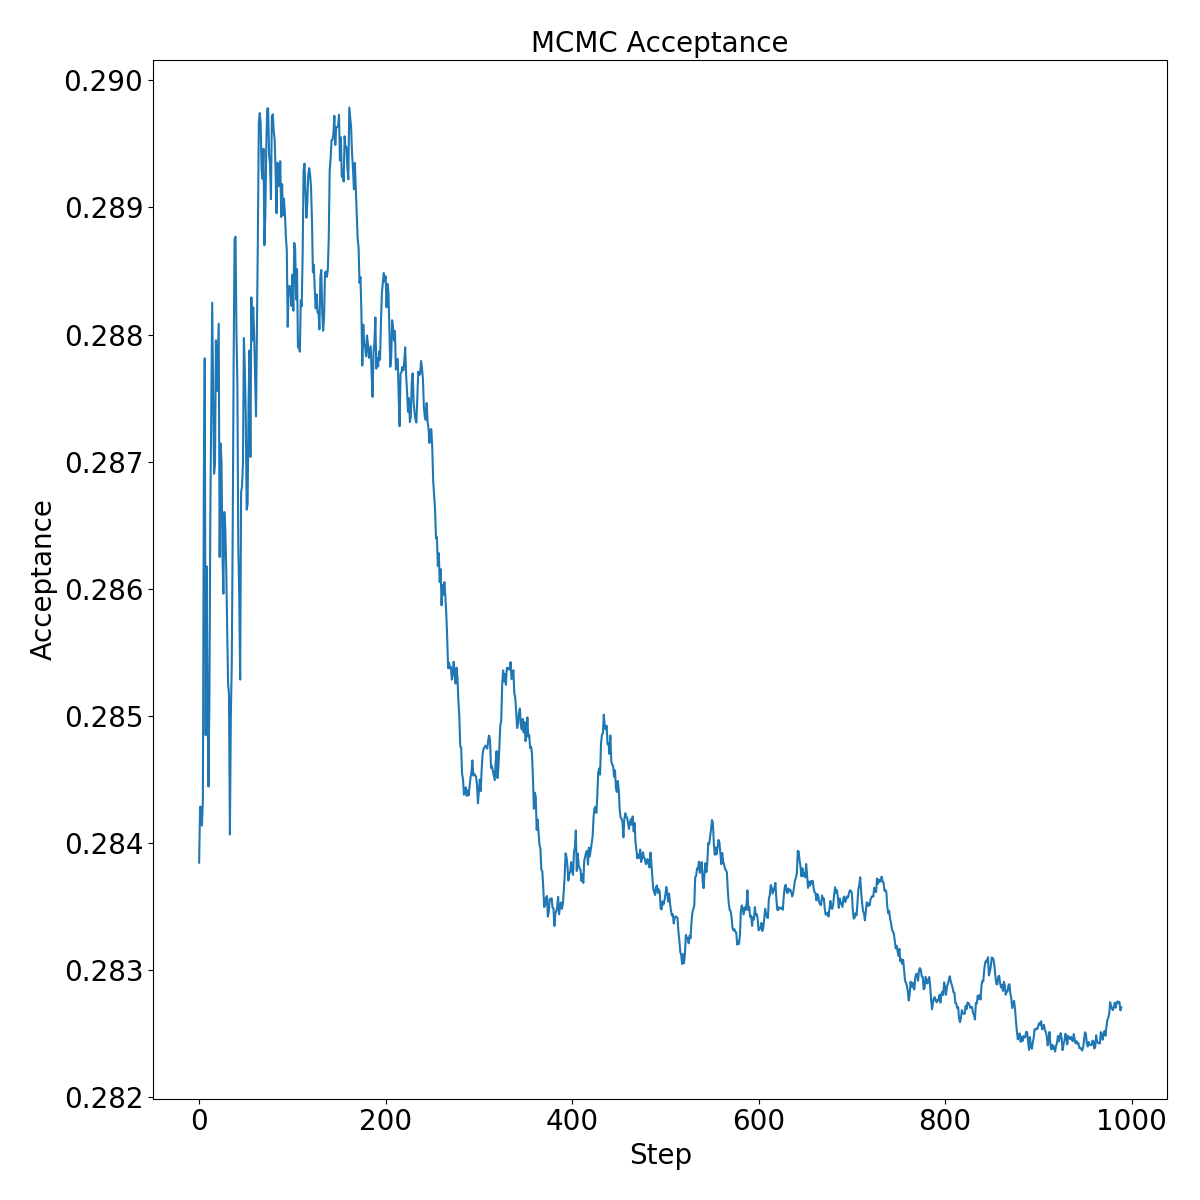

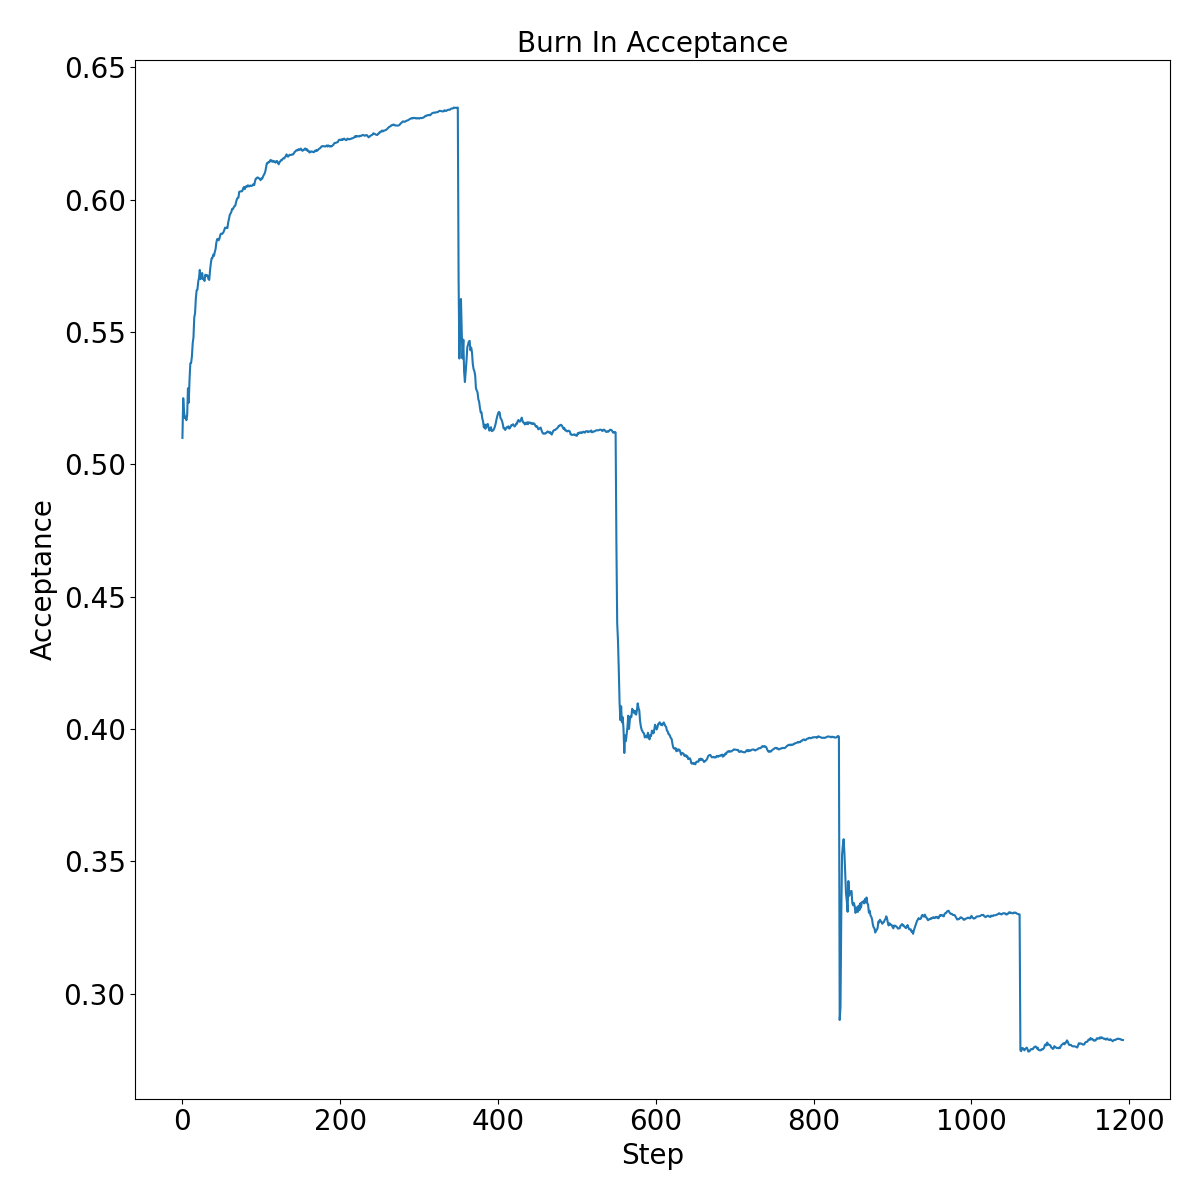

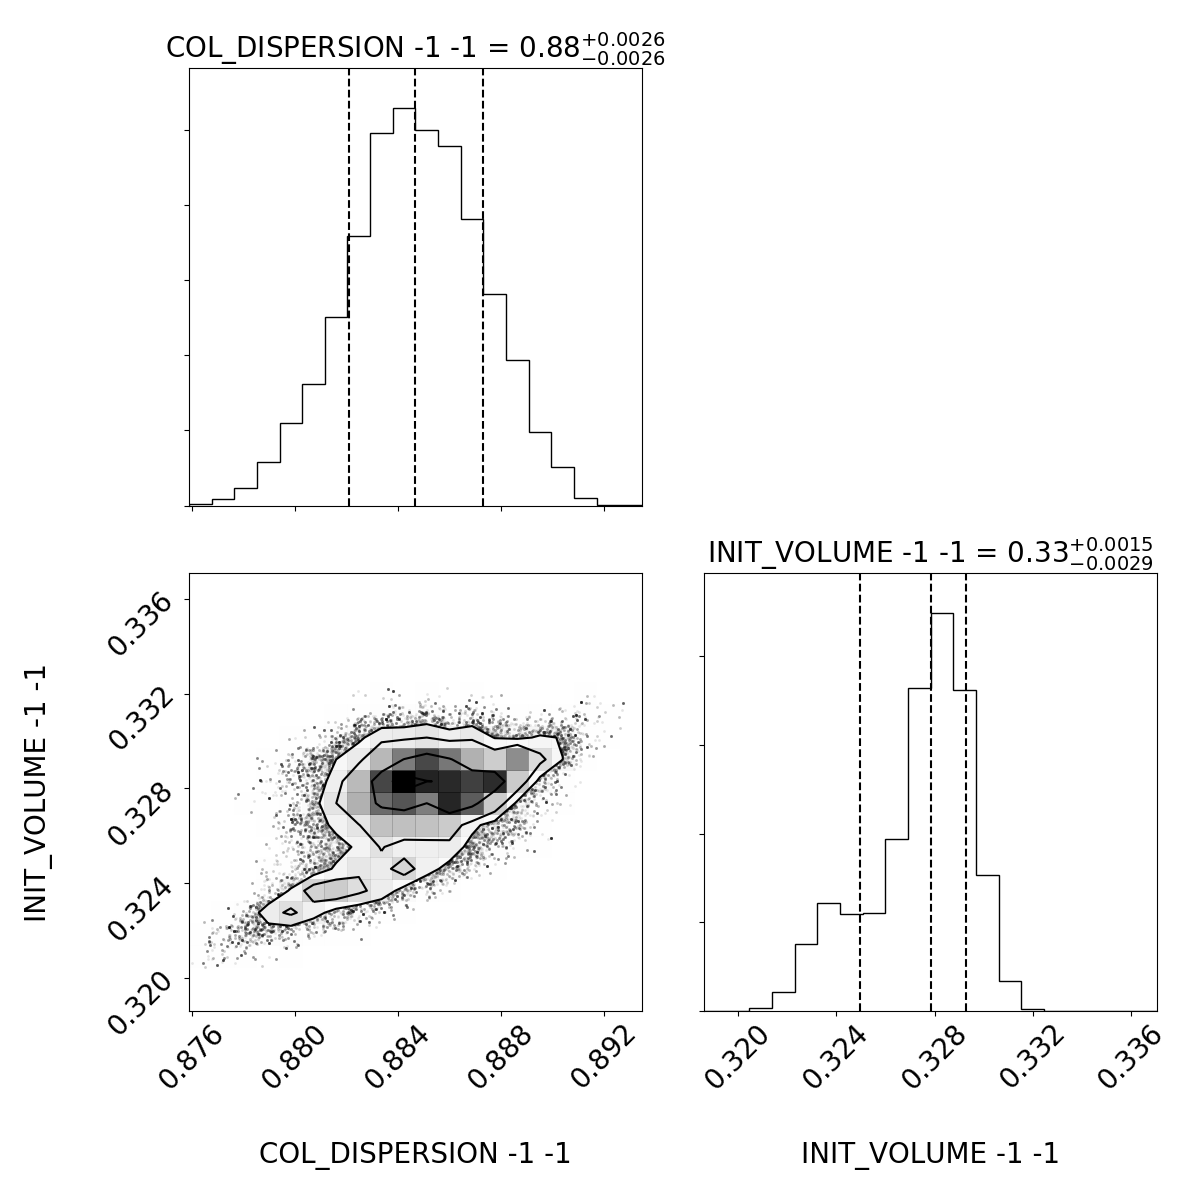

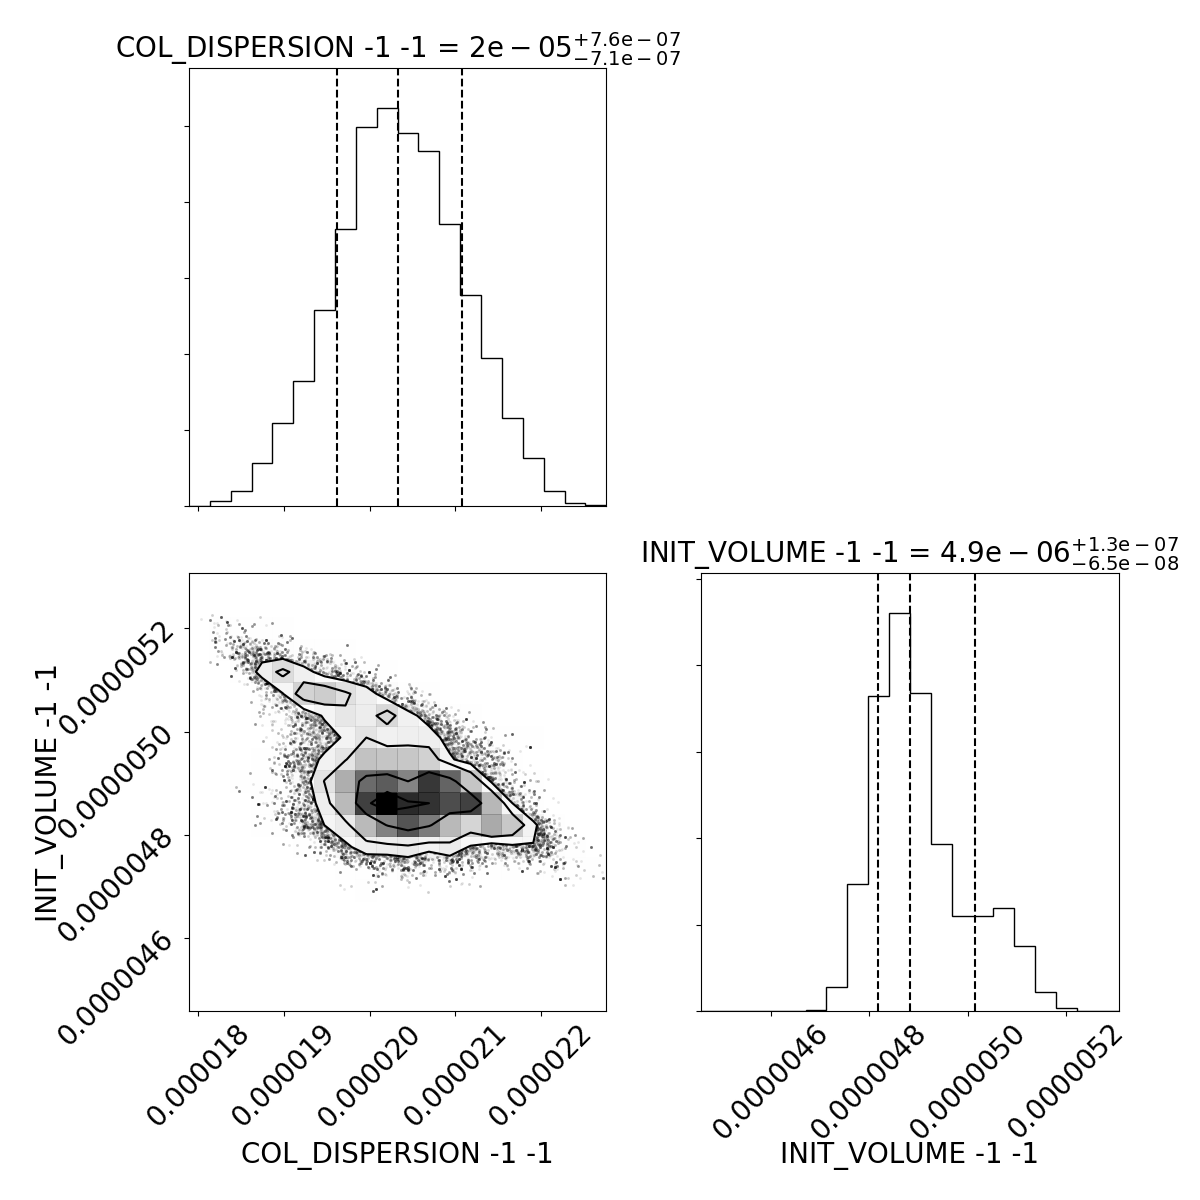

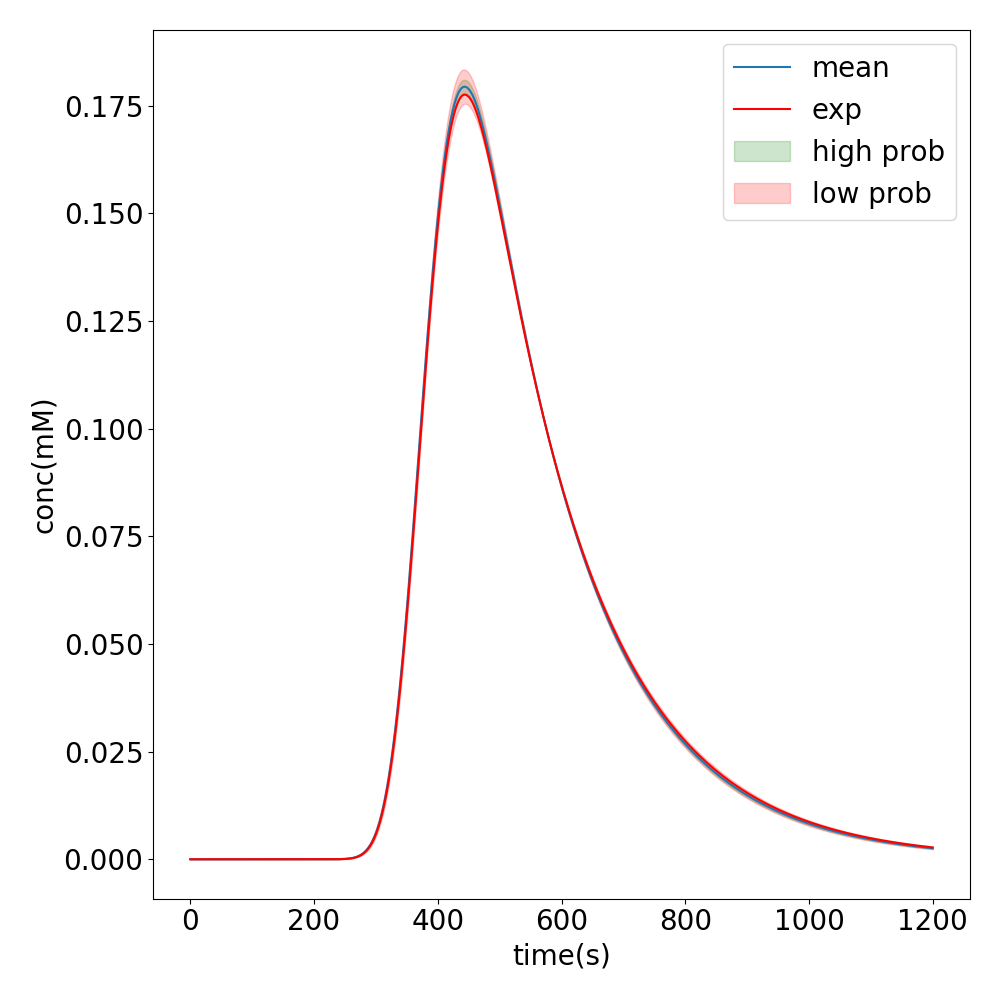

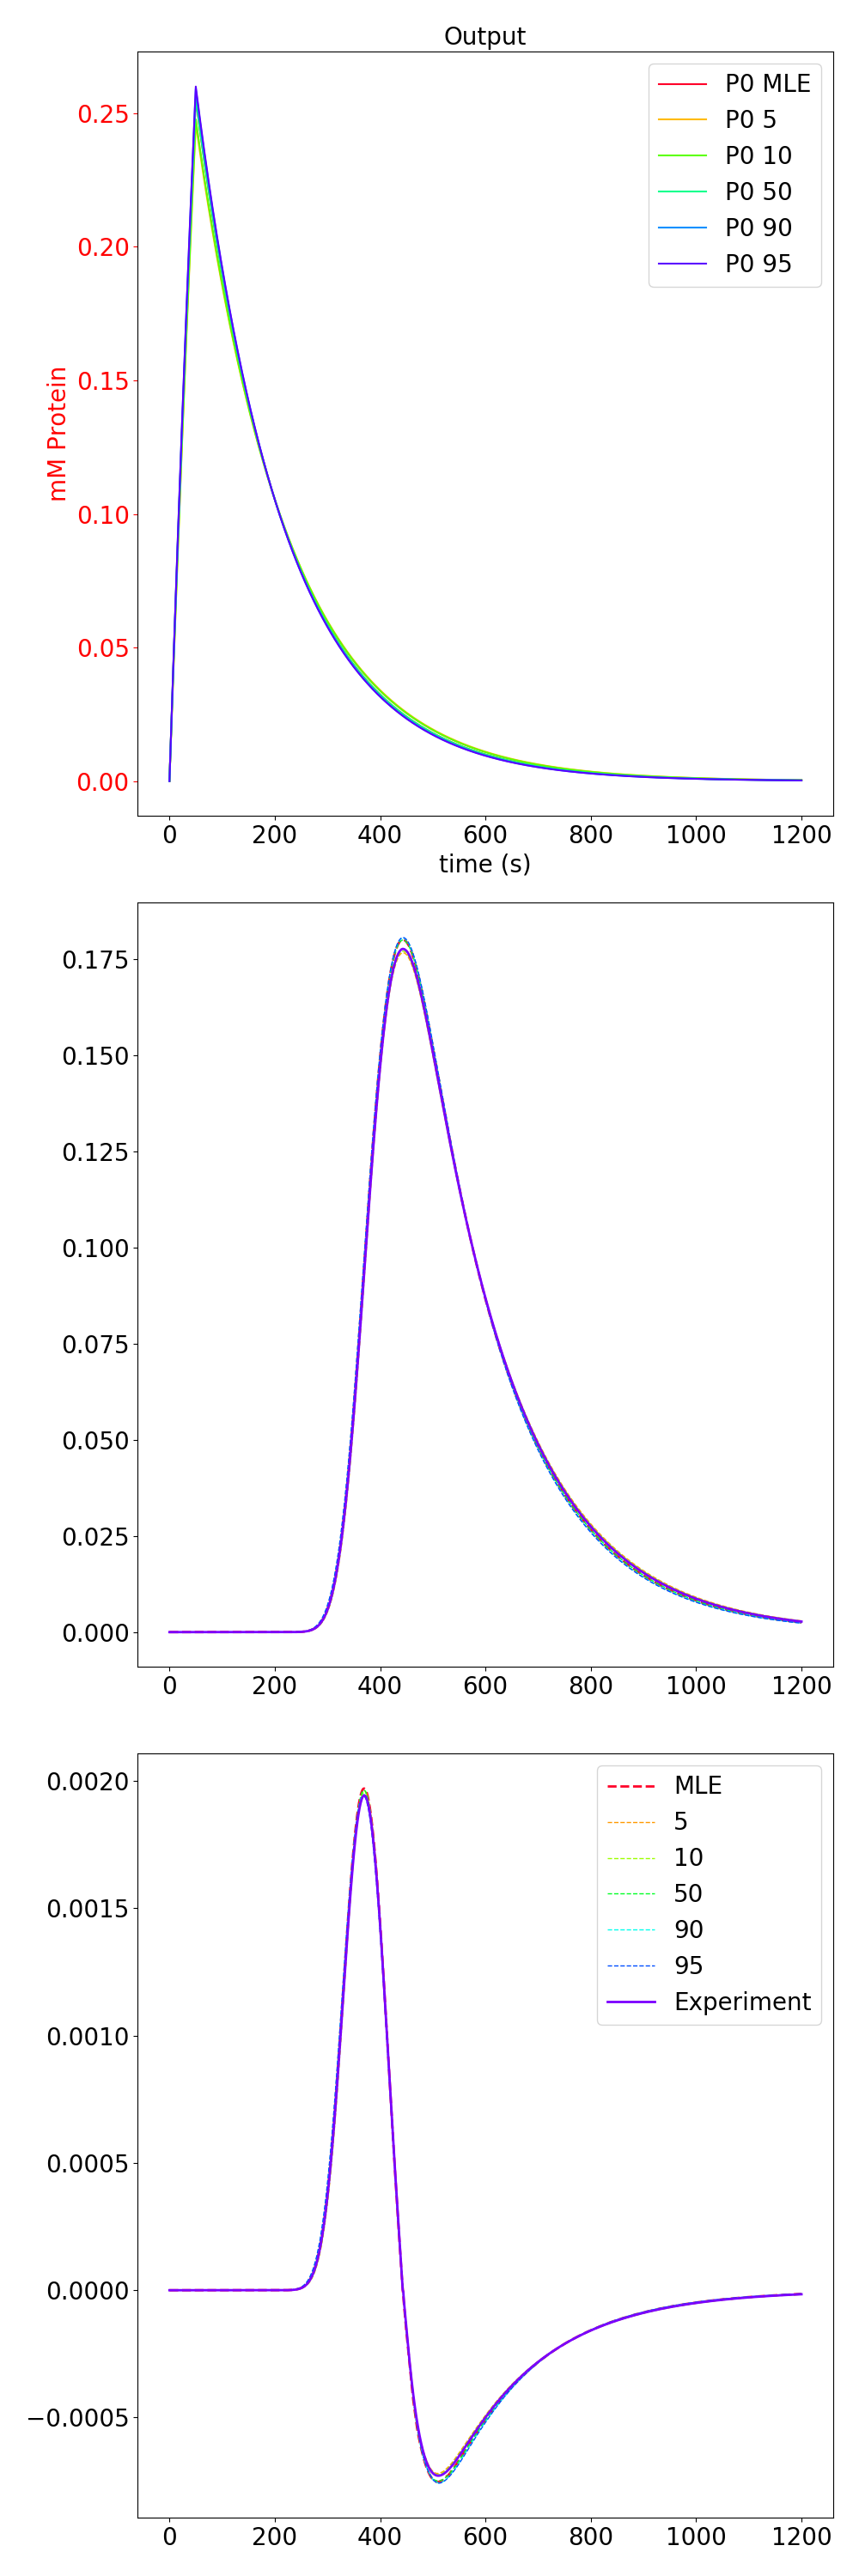

In [4]:
#look at the overall progress
display(Image( (example_dir_0 / match0.resultsDir / 'mcmc_refine' / 'progress' / 'tau_percent.png').as_posix(), width=800 ))

#look at burn in process
display(Image( (example_dir_0 / match0.resultsDir / 'mcmc_refine' / 'progress' / 'mcmc_acceptance.png').as_posix(), width=800 ))

#look at the acceptance
display(Image( (example_dir_0 / match0.resultsDir / 'mcmc_refine' / 'progress' / 'burn_in_acceptance.png').as_posix(), width=800 ))

#look at the distributions in search space
display(Image( (example_dir_0 / match0.resultsDir / 'mcmc_refine' / 'progress' / 'full_corner.png').as_posix(), width=800 ))

#look at the distributions in original space
display(Image( (example_dir_0 / match0.resultsDir / 'mcmc_refine' / 'progress' / 'full_corner_transform.png').as_posix(), width=800 ))

#look at output distribution
display(Image( (example_dir_0 / match0.resultsDir / 'mcmc_refine' / 'space' / 'mcmc' / 'main_unit_002_0.png').as_posix(), width=800 ))

#look at maximum likelihood
display(Image( (example_dir_0 / match0.resultsDir / 'mcmc_refine' / 'mcmc' / 'main_stats.png').as_posix(), width=800 ))

## View stats

In [5]:
true_values0 = numpy.array([example0.root.input.model.unit_003.col_dispersion, 
                           example0.root.input.model.unit_001.init_volume,])

df = pandas.read_csv( (example_dir_0 / match0.resultsDir / 'mcmc_refine' / 'mcmc' / 'prob.csv').as_posix() )
display(df.style.format({'COL_DISPERSION Comp:-1 Bound:-1':"{:.2g}" , 'INIT_VOLUME Comp:-1 Bound:-1': "{:.2g}"}))

print("Synthetic starting values")
print("Column dispersion %.2g" % true_values0[0])
print("CSTR volume       %.2g" % true_values0[1])

Synthetic starting values
Column dispersion 2e-05
CSTR volume       5e-06


# Create Dextran experiment

We can now carry forward with a Dextran pulse through the column and take into account the error already accounted for in the bypass experiment.

For this we will use the same experiment but this time we won't remove the column.

CompletedProcess(args=['C:/Users/kosh_000/CADET/cadet/bin/cadet-cli.exe', 'C:/Users/kosh_000/CADET/lessons/lesson_9/example_1/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


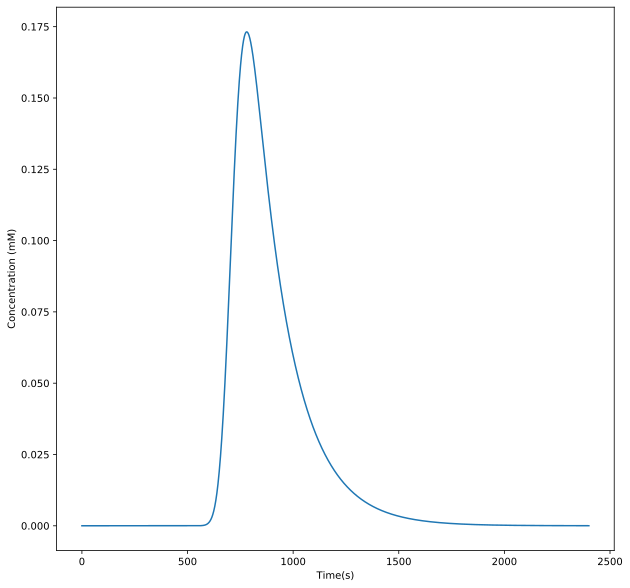

In [6]:
example_dir_1 = lesson_9 / "example_1"
example_dir_1.mkdir(exist_ok = True, parents=True)

example1 = Cadet()

#give a filename for where the simulation should be saved
example1.filename = (lesson_3 / "example_2" / 'example.h5').as_posix()

example1.load()

example1.filename = (example_dir_1 / 'example.h5').as_posix()

#change unit_001 parameters for a dextran pulse experiment

example1.root.input.model.unit_001.adsorption_model = 'NONE'
del example1.root.input.model.unit_001.adsorption

example1.root.input.model.unit_001.init_c = [0.0,]
example1.root.input.model.unit_001.init_q = [0.0,]
example1.root.input.model.unit_001.discretization.nbound = [0,]
example1.root.input.model.unit_001.film_diffusion = [0.0,]


#lower components to 1
example1.root.input.model.unit_001.ncomp = 1
example1.root.input.model.unit_002.ncomp = 1
example1.root.input.model.unit_003.ncomp = 1
example1.root.input.model.unit_004.ncomp = 1
example1.root.input.model.unit_005.ncomp = 1

example1.root.input.model.unit_003.discretization.nbound = [0,]
example1.root.input.model.unit_004.discretization.nbound = [0,]

#change the inlet to 1 component
#change the inlet
example1.root.input.model.unit_000.ncomp = 1

example1.root.input.model.unit_000.sec_000.const_coeff = [1.0,]
example1.root.input.model.unit_000.sec_000.lin_coeff = [0.0,]
example1.root.input.model.unit_000.sec_000.quad_coeff = [0.0,]
example1.root.input.model.unit_000.sec_000.cube_coeff = [0.0,]

example1.root.input.model.unit_000.sec_001.const_coeff = [0.0,]
example1.root.input.model.unit_000.sec_001.lin_coeff = [0.0,]
example1.root.input.model.unit_000.sec_001.quad_coeff = [0.0,]
example1.root.input.model.unit_000.sec_001.cube_coeff = [0.0,]

del example1.root.input.model.unit_000.sec_002

#change the sections and section times

#solver settings
example1.root.input.solver.sections.section_times = [0.0, 50, 2400]

#set the times that the simulator writes out data for
example1.root.input.solver.user_solution_times = numpy.linspace(0, example1.root.input.solver.sections.section_times[-1], 
                                                               int(example1.root.input.solver.sections.section_times[-1]) + 1)

example1.root.input.solver.sections.nsec = len(example1.root.input.solver.sections.section_times) - 1


#save the simulation
example1.save()

#run the simulation
data = example1.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    example1.load()
    
    #plot the simulation
    plt.figure(figsize=[10,10])
    plt.plot(example1.root.output.solution.solution_times,
        example1.root.output.solution.unit_002.solution_outlet_comp_000)
    plt.xlabel('Time(s)')
    plt.ylabel('Concentration (mM)')
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([example1.root.output.solution.solution_times,
                        example1.root.output.solution.unit_002.solution_outlet_comp_000]).transpose()
    data.to_csv((example_dir_1 / 'example.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

## Create configuration file

This configuration file is almost the same as before. The only complication is we have to include the previous mcmc results to use in this estimation.

In [7]:
match1 = Dict()
match1.CADETPath = cadet_path.as_posix()
match1.baseDir = example_dir_1.as_posix()
match1.resultsDir = 'fit_mcmc'
match1.csv = 'fit_results.csv'
match1.checkpointFile = "check"
match1.searchMethod = 'NSGA3'
match1.population = 50
match1.finalGradRefinement = 0
match1.stallGenerations = 10
match1.continueMCMC = 1
match1.tempDir = '/dev/shm'

#This is important, there is where we tell the system how to find the previous probability information
match1.mcmc_h5 = (example_dir_0 / match0.resultsDir / 'mcmc_refine' / 'mcmc' / 'mcmc.h5').as_posix()

error_model = Dict()
error_model.file_path = "example.h5"
error_model.experimental_csv = "example.csv"
error_model.name = "main"
error_model.units = [2,]
error_model.delay = [0.0, 3.0]
error_model.flow = [1.0, 0.03]
error_model.load = [1.0, 0.03]
error_model.error_slope = [1.0, 0.001]
error_model.error_base = 50.0
error_model.base = 50.0
error_model.count = 1000

match1.kde_synthetic = [error_model,]


#add the previous parameters to the estimation
parameter1 = Dict()
parameter1.transform = 'norm_log'
parameter1.component = -1
parameter1.bound = -1
parameter1.location = "/input/model/unit_003/COL_DISPERSION"
parameter1.min = 1e-10
parameter1.max = 1e-4

parameter2 = Dict()
parameter2.transform = 'set_value'
parameter2.componentFrom = -1
parameter2.boundFrom = -1
parameter2.locationFrom = "/input/model/unit_003/COL_DISPERSION"
parameter2.componentTo = -1
parameter2.boundTo = -1
parameter2.locationTo = "/input/model/unit_004/COL_DISPERSION"

parameter3 = Dict()
parameter3.transform = 'norm_log'
parameter3.component = -1
parameter3.bound = -1
parameter3.location = "/input/model/unit_001/INIT_VOLUME"
parameter3.min = 1e-4
parameter3.max = 1e-8

match1.parameters_mcmc = [parameter1, parameter2, parameter3]

parameter1 = Dict()
parameter1.transform = 'norm_log'
parameter1.component = -1
parameter1.bound = -1
parameter1.location = "/input/model/unit_001/COL_DISPERSION"
parameter1.min = 1e-10
parameter1.max = 1e-4

parameter2 = Dict()
parameter2.transform = 'norm'
parameter2.component = -1
parameter2.bound = -1
parameter2.location = "/input/model/unit_001/COL_POROSITY"
parameter2.min = 0.1
parameter2.max = 0.9

match1.parameters = [parameter1, parameter2]

experiment1 = Dict()
experiment1.csv = "example.csv"
experiment1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
experiment1.HDF5 = "example.h5"
experiment1.name = "main"

mle_dispersion = df.values[0, 1]
mle_volume = df.values[0, 2]

experiment1.set_values = [
                ["/input/model/unit_003/COL_DISPERSION", -1, mle_dispersion],
                ["/input/model/unit_004/COL_DISPERSION", -1, mle_dispersion],
                ["/input/model/unit_005/INIT_VOLUME", -1, mle_volume]
                ]

feature1 = Dict()
feature1.name = "Pulse"
feature1.type = 'ShapeDecay'

experiment1.features = [feature1,]

match1.experiments = [experiment1,]

match_file1 = example_dir_1 / 'example_bypass.json'

with (match_file1).open('w') as json_file:
    json.dump(match1.to_dict(), json_file, indent='\t')

## Run match

Your results are located at /home/IBT/heymann/CADET/lessons/lesson_9/example_1/fit_mcmc 


[2019-10-22 07:56:23,429] launcher  INFO    SCOOP 0.7 1.1 on linux using Python 3.7.3 (default, Mar 27 2019, 22:11:17) [GCC 7.3.0], API: 1013

[2019-10-22 07:56:23,430] launcher  INFO    Deploying 64 worker(s) over 1 host(s).

[2019-10-22 07:56:23,430] launcher  INFO    Worker distribution: 

[2019-10-22 07:56:23,430] launcher  INFO       127.0.0.1:	63 + origin

[2019-10-22 07:57:17,772] util      (b'127.0.0.1:59519') INFO    example.h5 abstol=1.73e-05  reltol=0.0001

[2019-10-22 07:57:18,611] match     (b'127.0.0.1:59519') INFO    simulation took 0.8387954235076904

[2019-10-22 07:57:18,655] match     (b'127.0.0.1:59519') INFO    create bias template for experiment main

[2019-10-22 07:57:19,724] gradFD    (b'127.0.0.1:59519') INFO    grad simulation took 0.9279024600982666

[2019-10-22 07:57:19,725] gradFD    (b'127.0.0.1:59519') INFO    grad /home/IBT/heymann/CADET/lessons/lesson_9/example_1/f

[2019-10-22 07:58:38,470] loggerwriter (b'127.0.0.1:64697') WARNING findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.



[2019-10-22 07:58:38,472] loggerwriter (b'127.0.0.1:64697') WARNING findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.



[2019-10-22 07:58:38,474] loggerwriter (b'127.0.0.1:64697') WARNING findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.



[2019-10-22 07:58:38,476] loggerwriter (b'127.0.0.1:64697') WARNING findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.



[2019-10-22 07:58:38,477] loggerwriter (b'127.0.0.1:64697') WARNING findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.



[2019-10-22 07:58:38,478] loggerwriter (b'127.0.0.1:64697') WARNING findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.



[2019-10-22 07:58:38,479] loggerwriter (b'127.0.0.1:64697') WARNING findfont: Font family ['STIXS

Time                              Name Method  \
2  Mon Oct 21 20:43:38 2019  7f29e53a8cc6ae7b15c9970011505d55    EVO   

   Condition Number  COL_DISPERSION Comp:-1 Bound:-1  \
2               NaN                     2.819257e-07   

   COL_POROSITY Comp:-1 Bound:-1  main_Pulse_Similarity  main_Pulse_Value  \
2                       0.367837               0.999983          0.993787   

   main_Pulse_Time  main_Pulse_Derivative_Similarity  \
2         0.999816                          0.999956   

   main_Pulse_Der_High_Value  main_Pulse_Der_Low_Value  Product Root Score  \
2                   0.994774                  0.983578            0.995298   

   Min Score  Mean Score       SSE  
2   0.983578    0.995316  0.000455

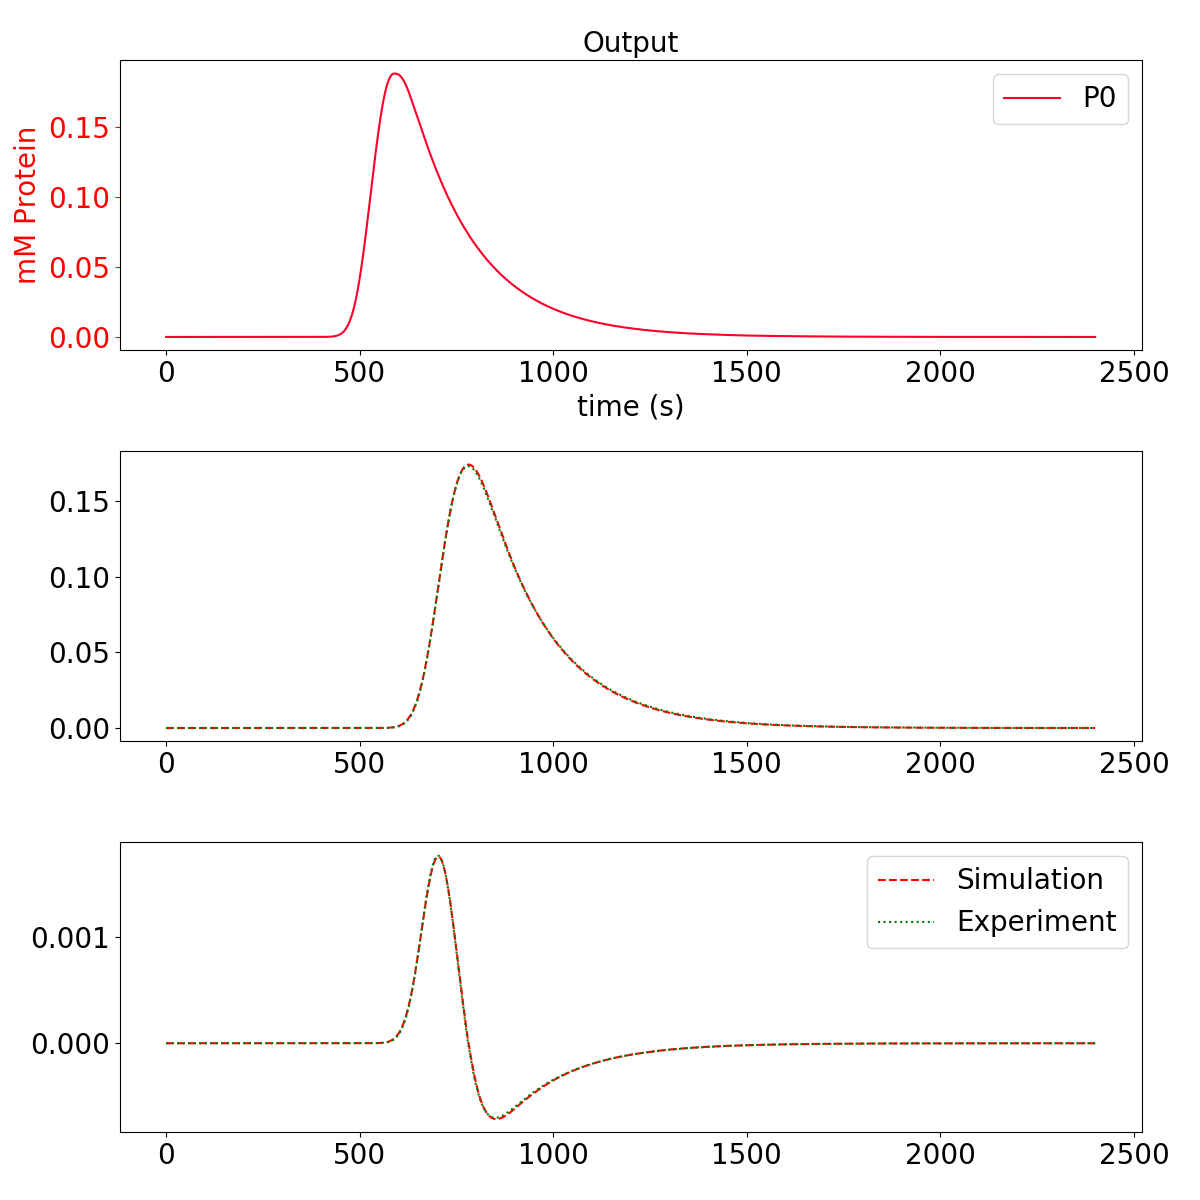

Best item 2a05d091b58f3e5fe880296bcc039ed1 for meta score(s) Min Score , SSE


Time                              Name Method  \
1  Mon Oct 21 20:43:12 2019  2a05d091b58f3e5fe880296bcc039ed1    EVO   

   Condition Number  COL_DISPERSION Comp:-1 Bound:-1  \
1               NaN                     2.690739e-07   

   COL_POROSITY Comp:-1 Bound:-1  main_Pulse_Similarity  main_Pulse_Value  \
1                       0.380334               0.999984          0.994944   

   main_Pulse_Time  main_Pulse_Derivative_Similarity  \
1         0.993019                          0.999934   

   main_Pulse_Der_High_Value  main_Pulse_Der_Low_Value  Product Root Score  \
1                   0.987082                  0.987282            0.993694   

   Min Score  Mean Score       SSE  
1   0.987082    0.993707  0.038457

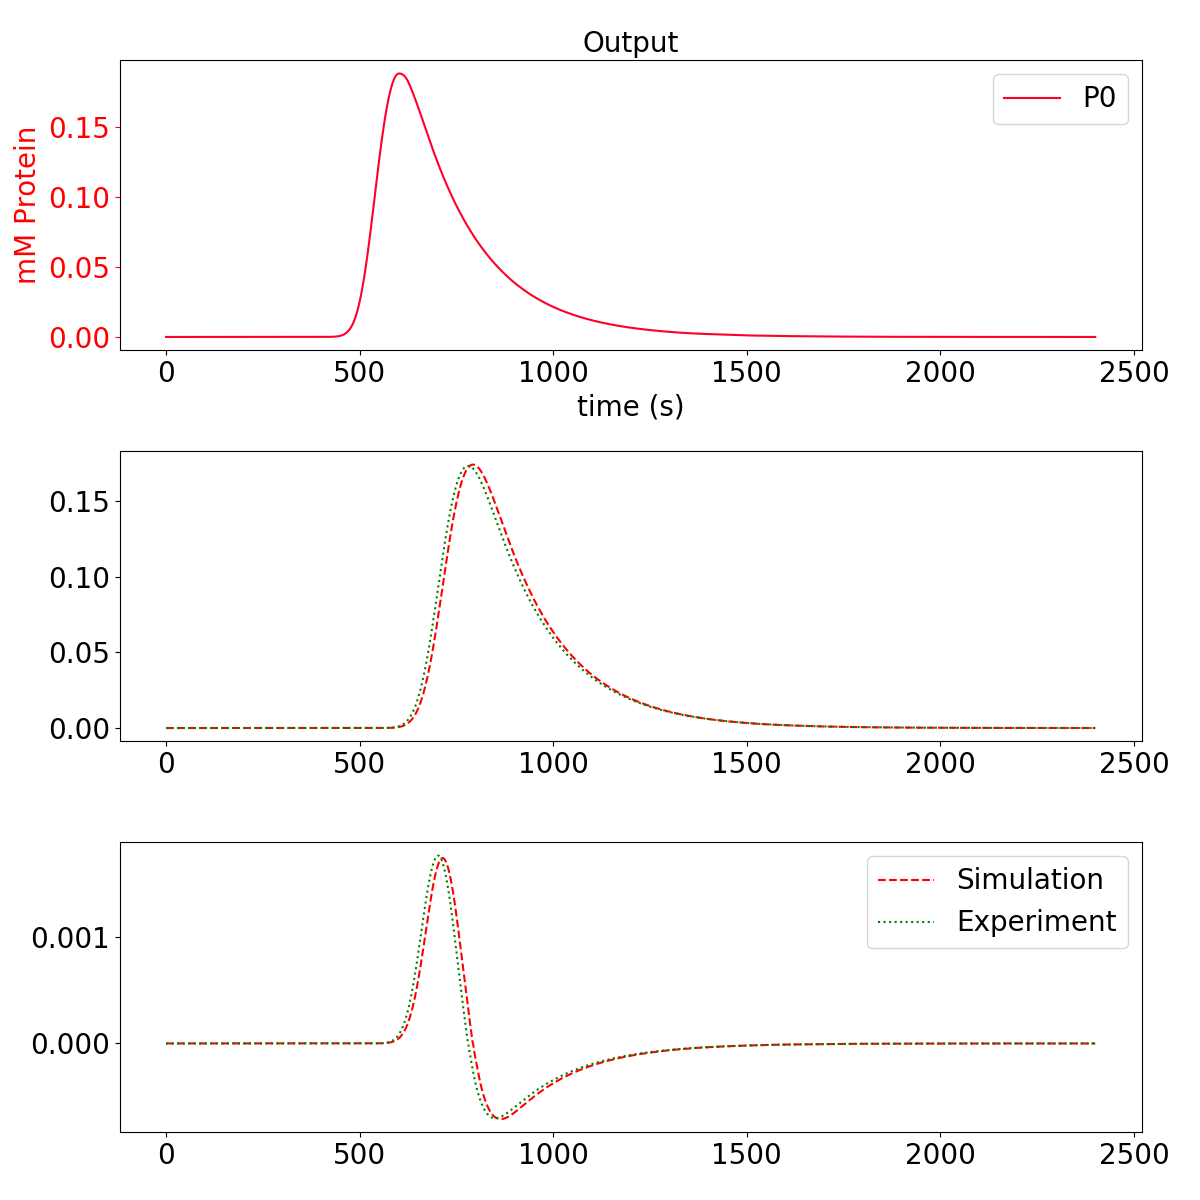

Method: Product Root Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.82e-07  true_value = 2.00e-07 error: 29%
COL_POROSITY Comp:-1 Bound:-1 = 3.68e-01  true_value = 3.70e-01 error: 0.59%


Method: Min Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.69e-07  true_value = 2.00e-07 error: 26%
COL_POROSITY Comp:-1 Bound:-1 = 3.80e-01  true_value = 3.70e-01 error: 2.7%


Method: Mean Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.82e-07  true_value = 2.00e-07 error: 29%
COL_POROSITY Comp:-1 Bound:-1 = 3.68e-01  true_value = 3.70e-01 error: 0.59%


Method: SSE
COL_DISPERSION Comp:-1 Bound:-1 = 2.69e-07  true_value = 2.00e-07 error: 26%
COL_POROSITY Comp:-1 Bound:-1 = 3.80e-01  true_value = 3.70e-01 error: 2.7%




In [12]:
true_values1 = numpy.array([example1.root.input.model.unit_001.col_dispersion, 
                           example1.root.input.model.unit_001.col_porosity,
                            example1.root.input.model.unit_003.col_dispersion, 
                           example1.root.input.model.unit_005.init_volume,])
    
sim1 = run_match(match1,
                    match_file1,
                    true_values1,
                    delete=False)

## View results

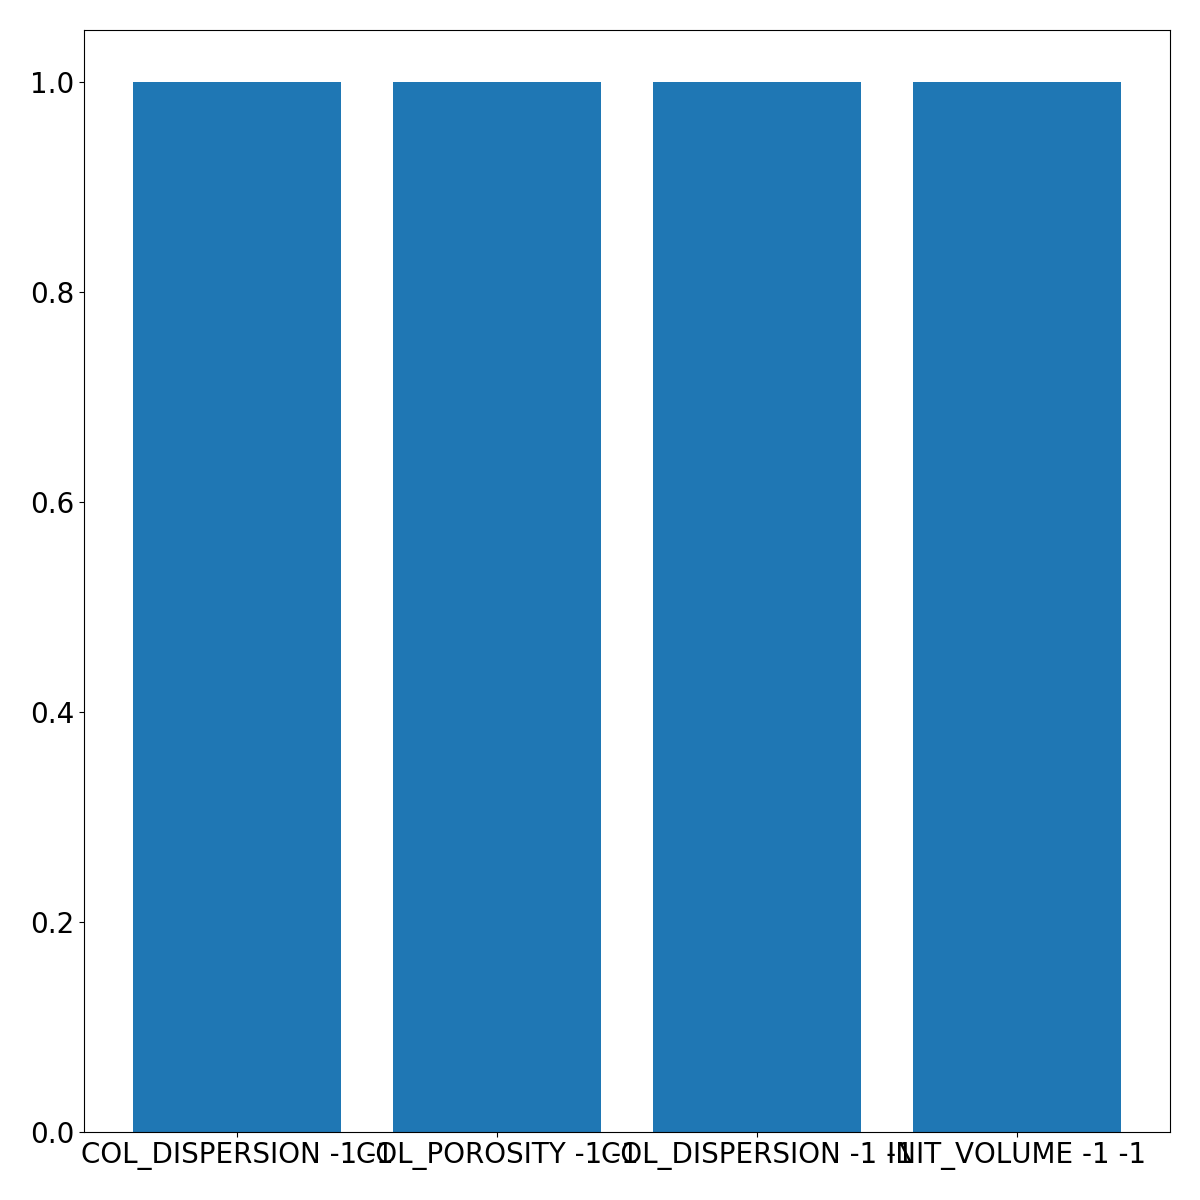

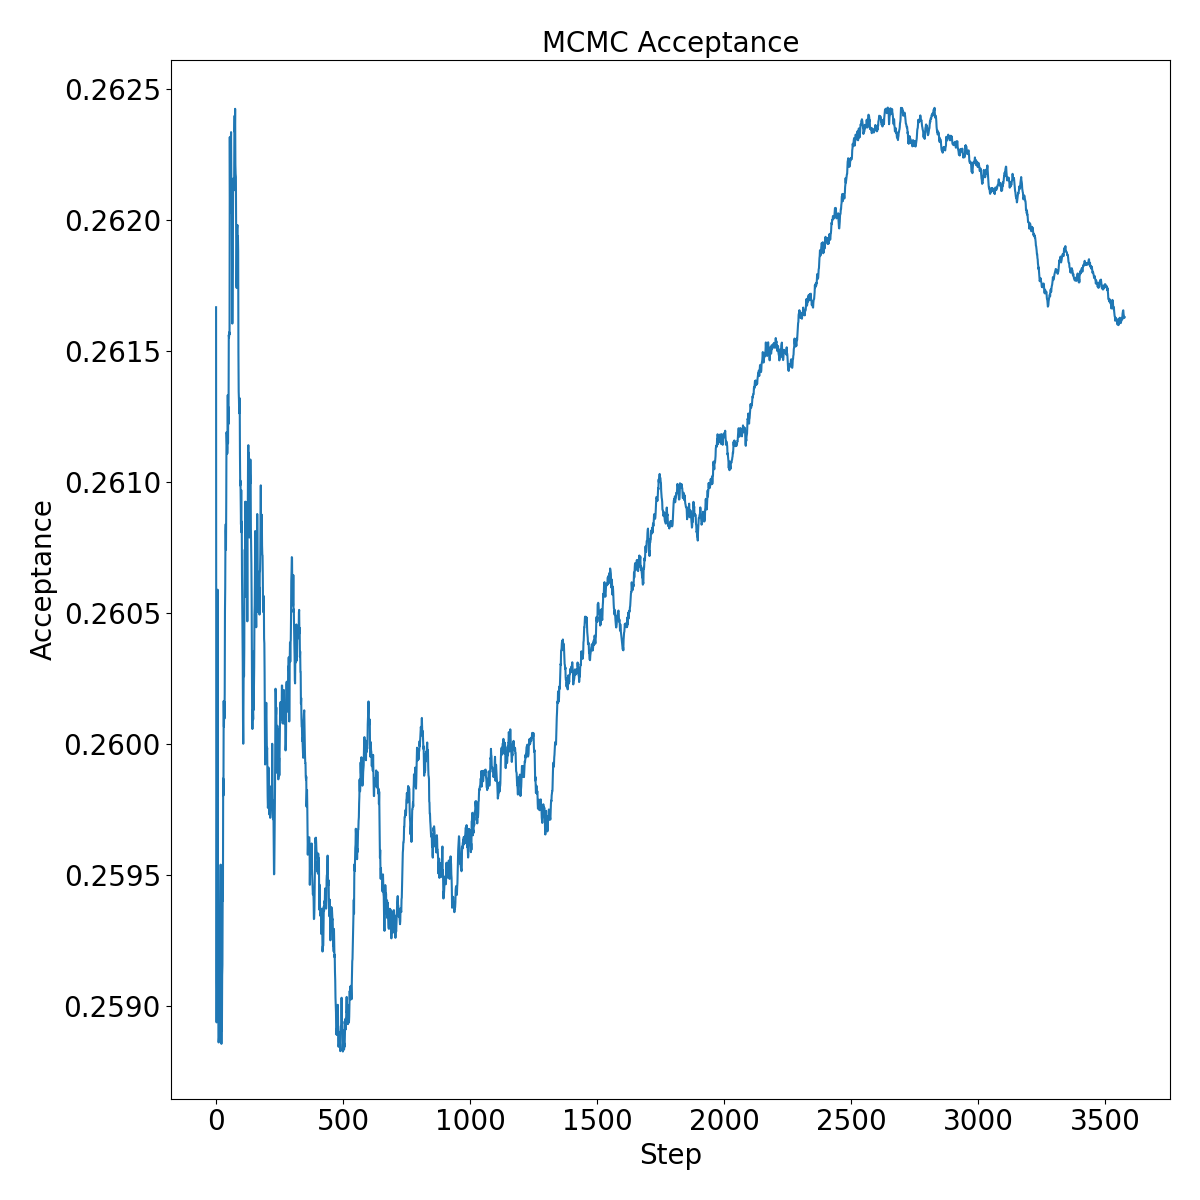

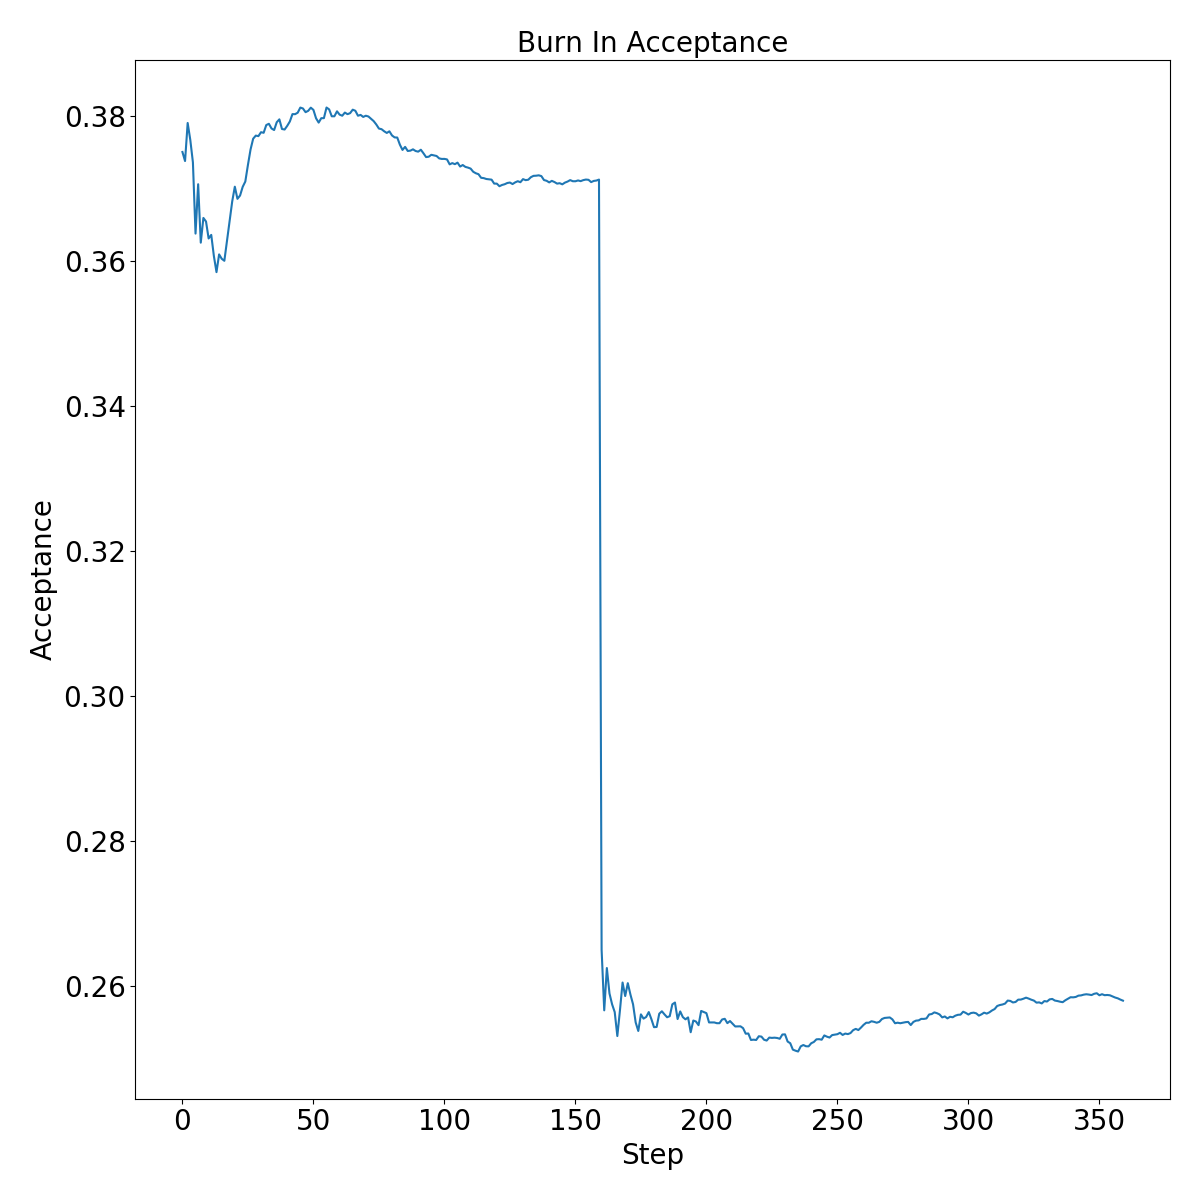

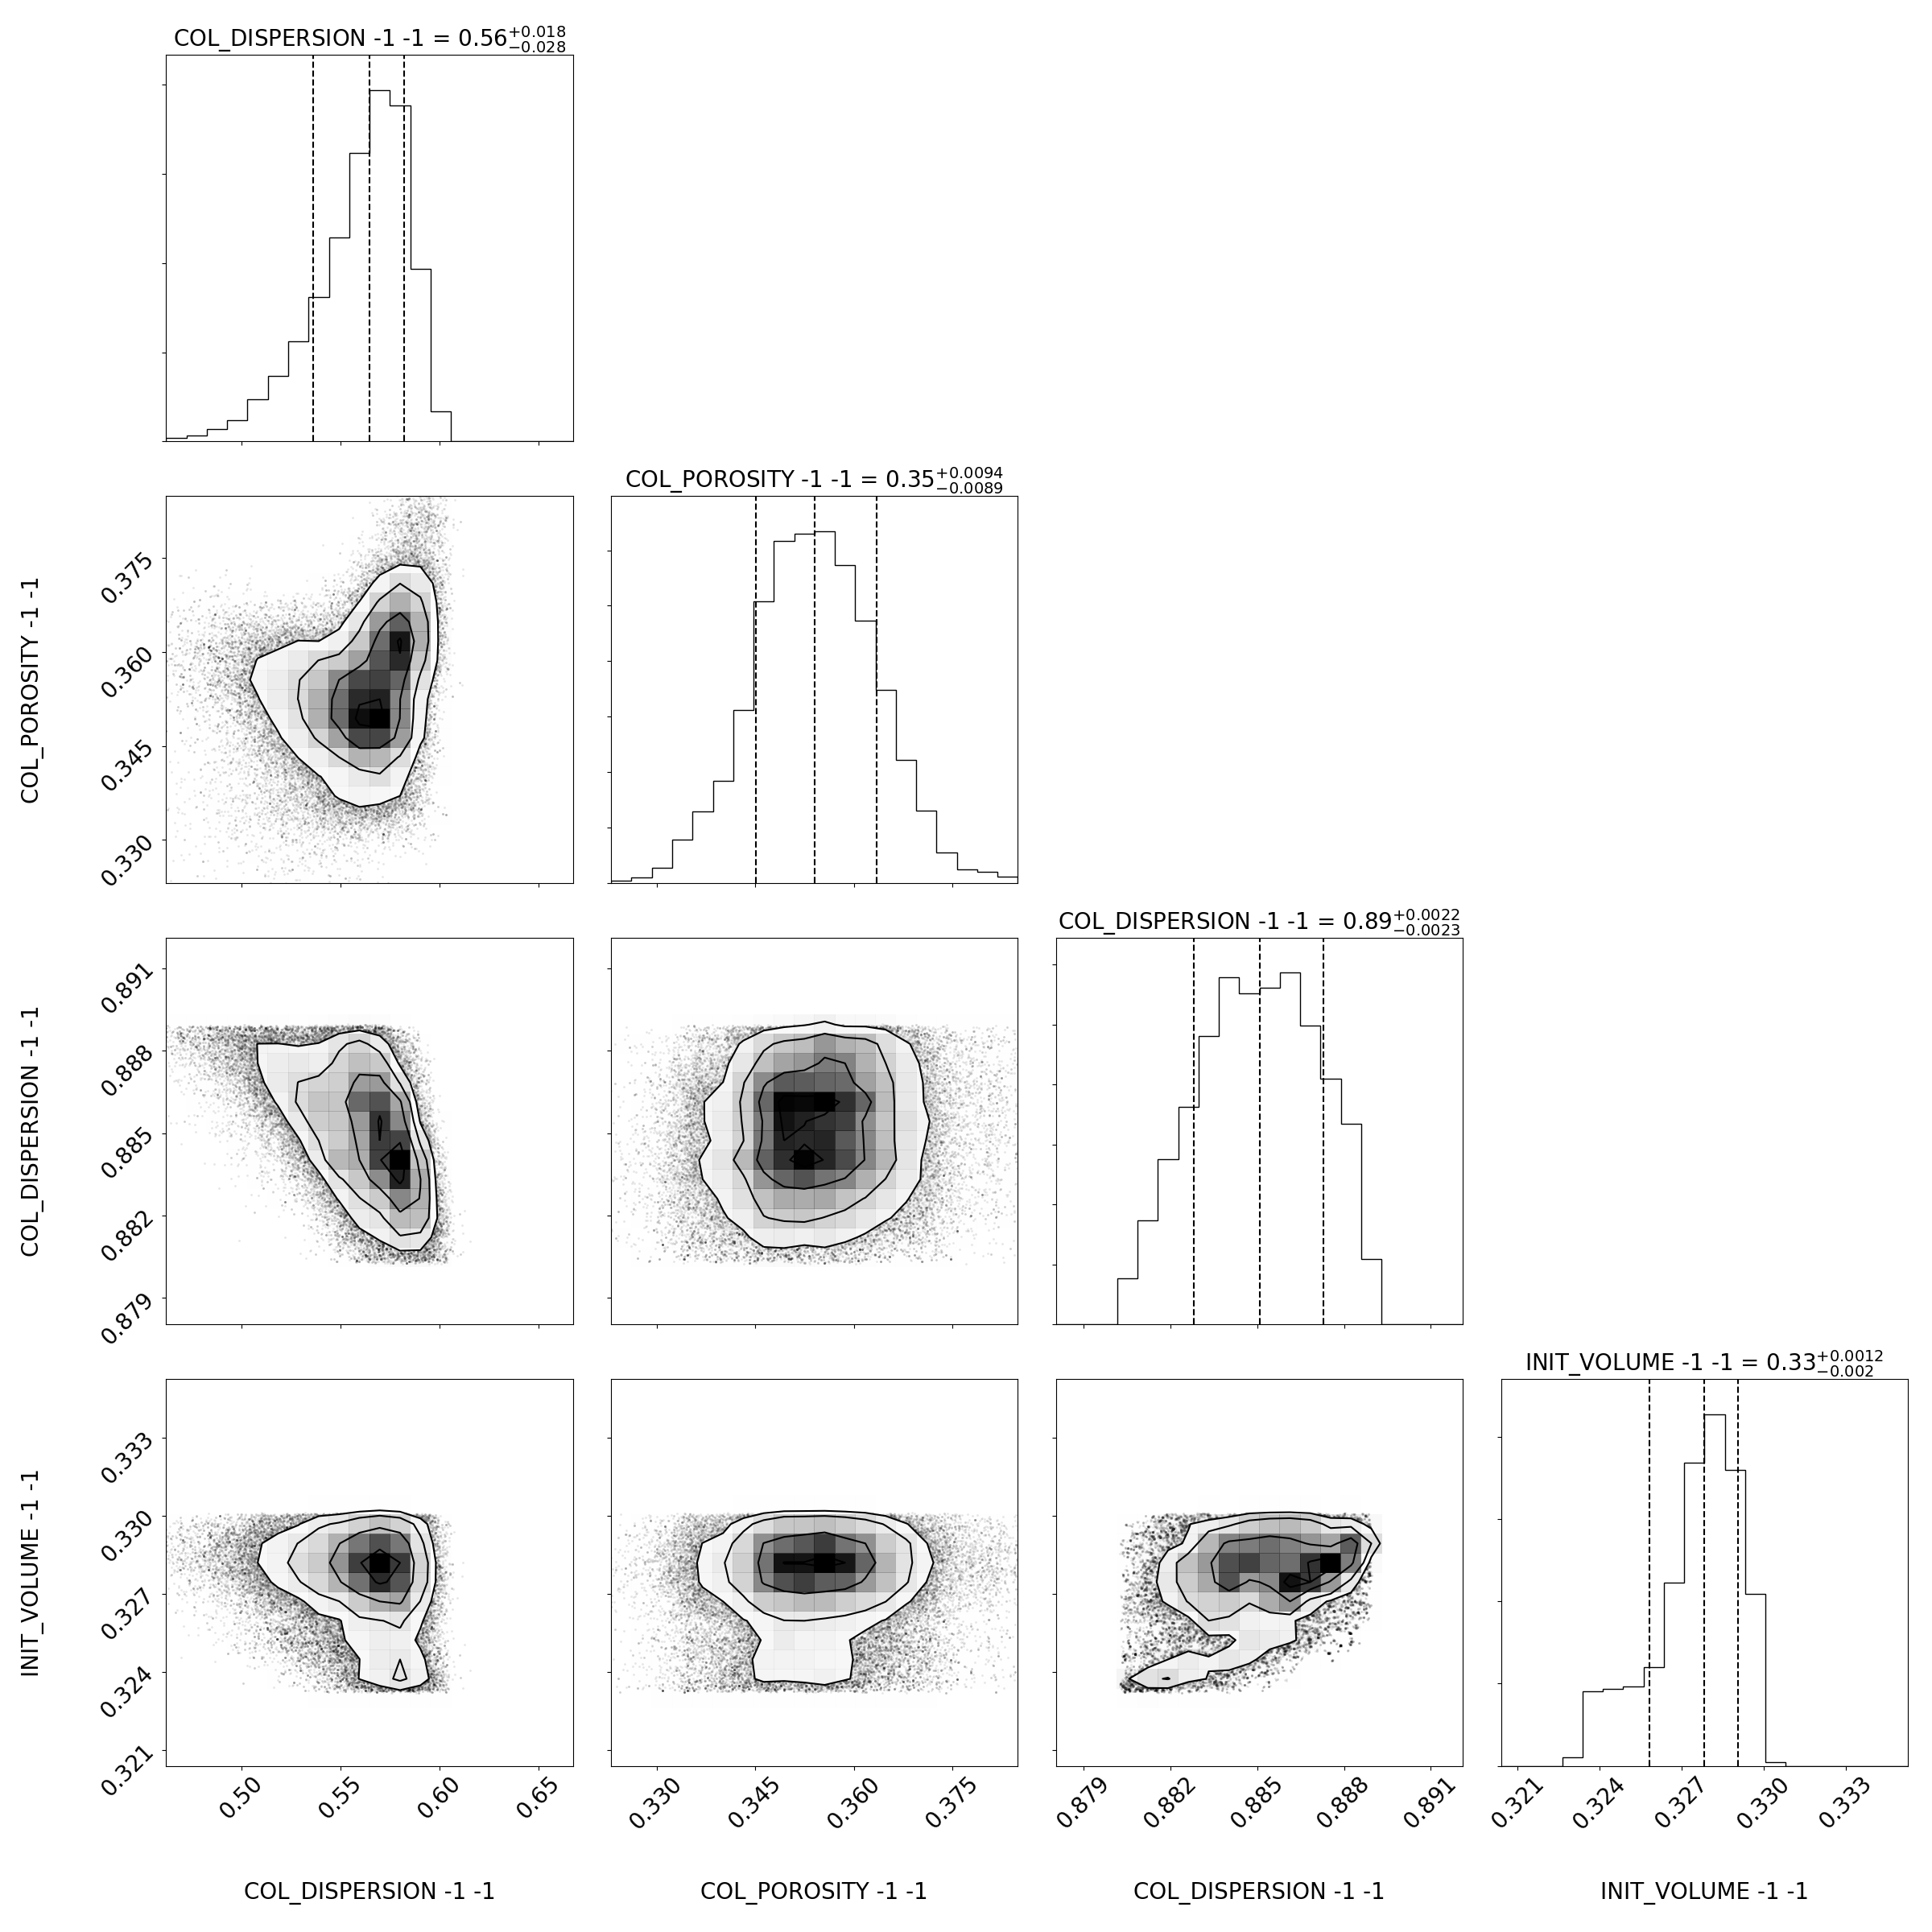

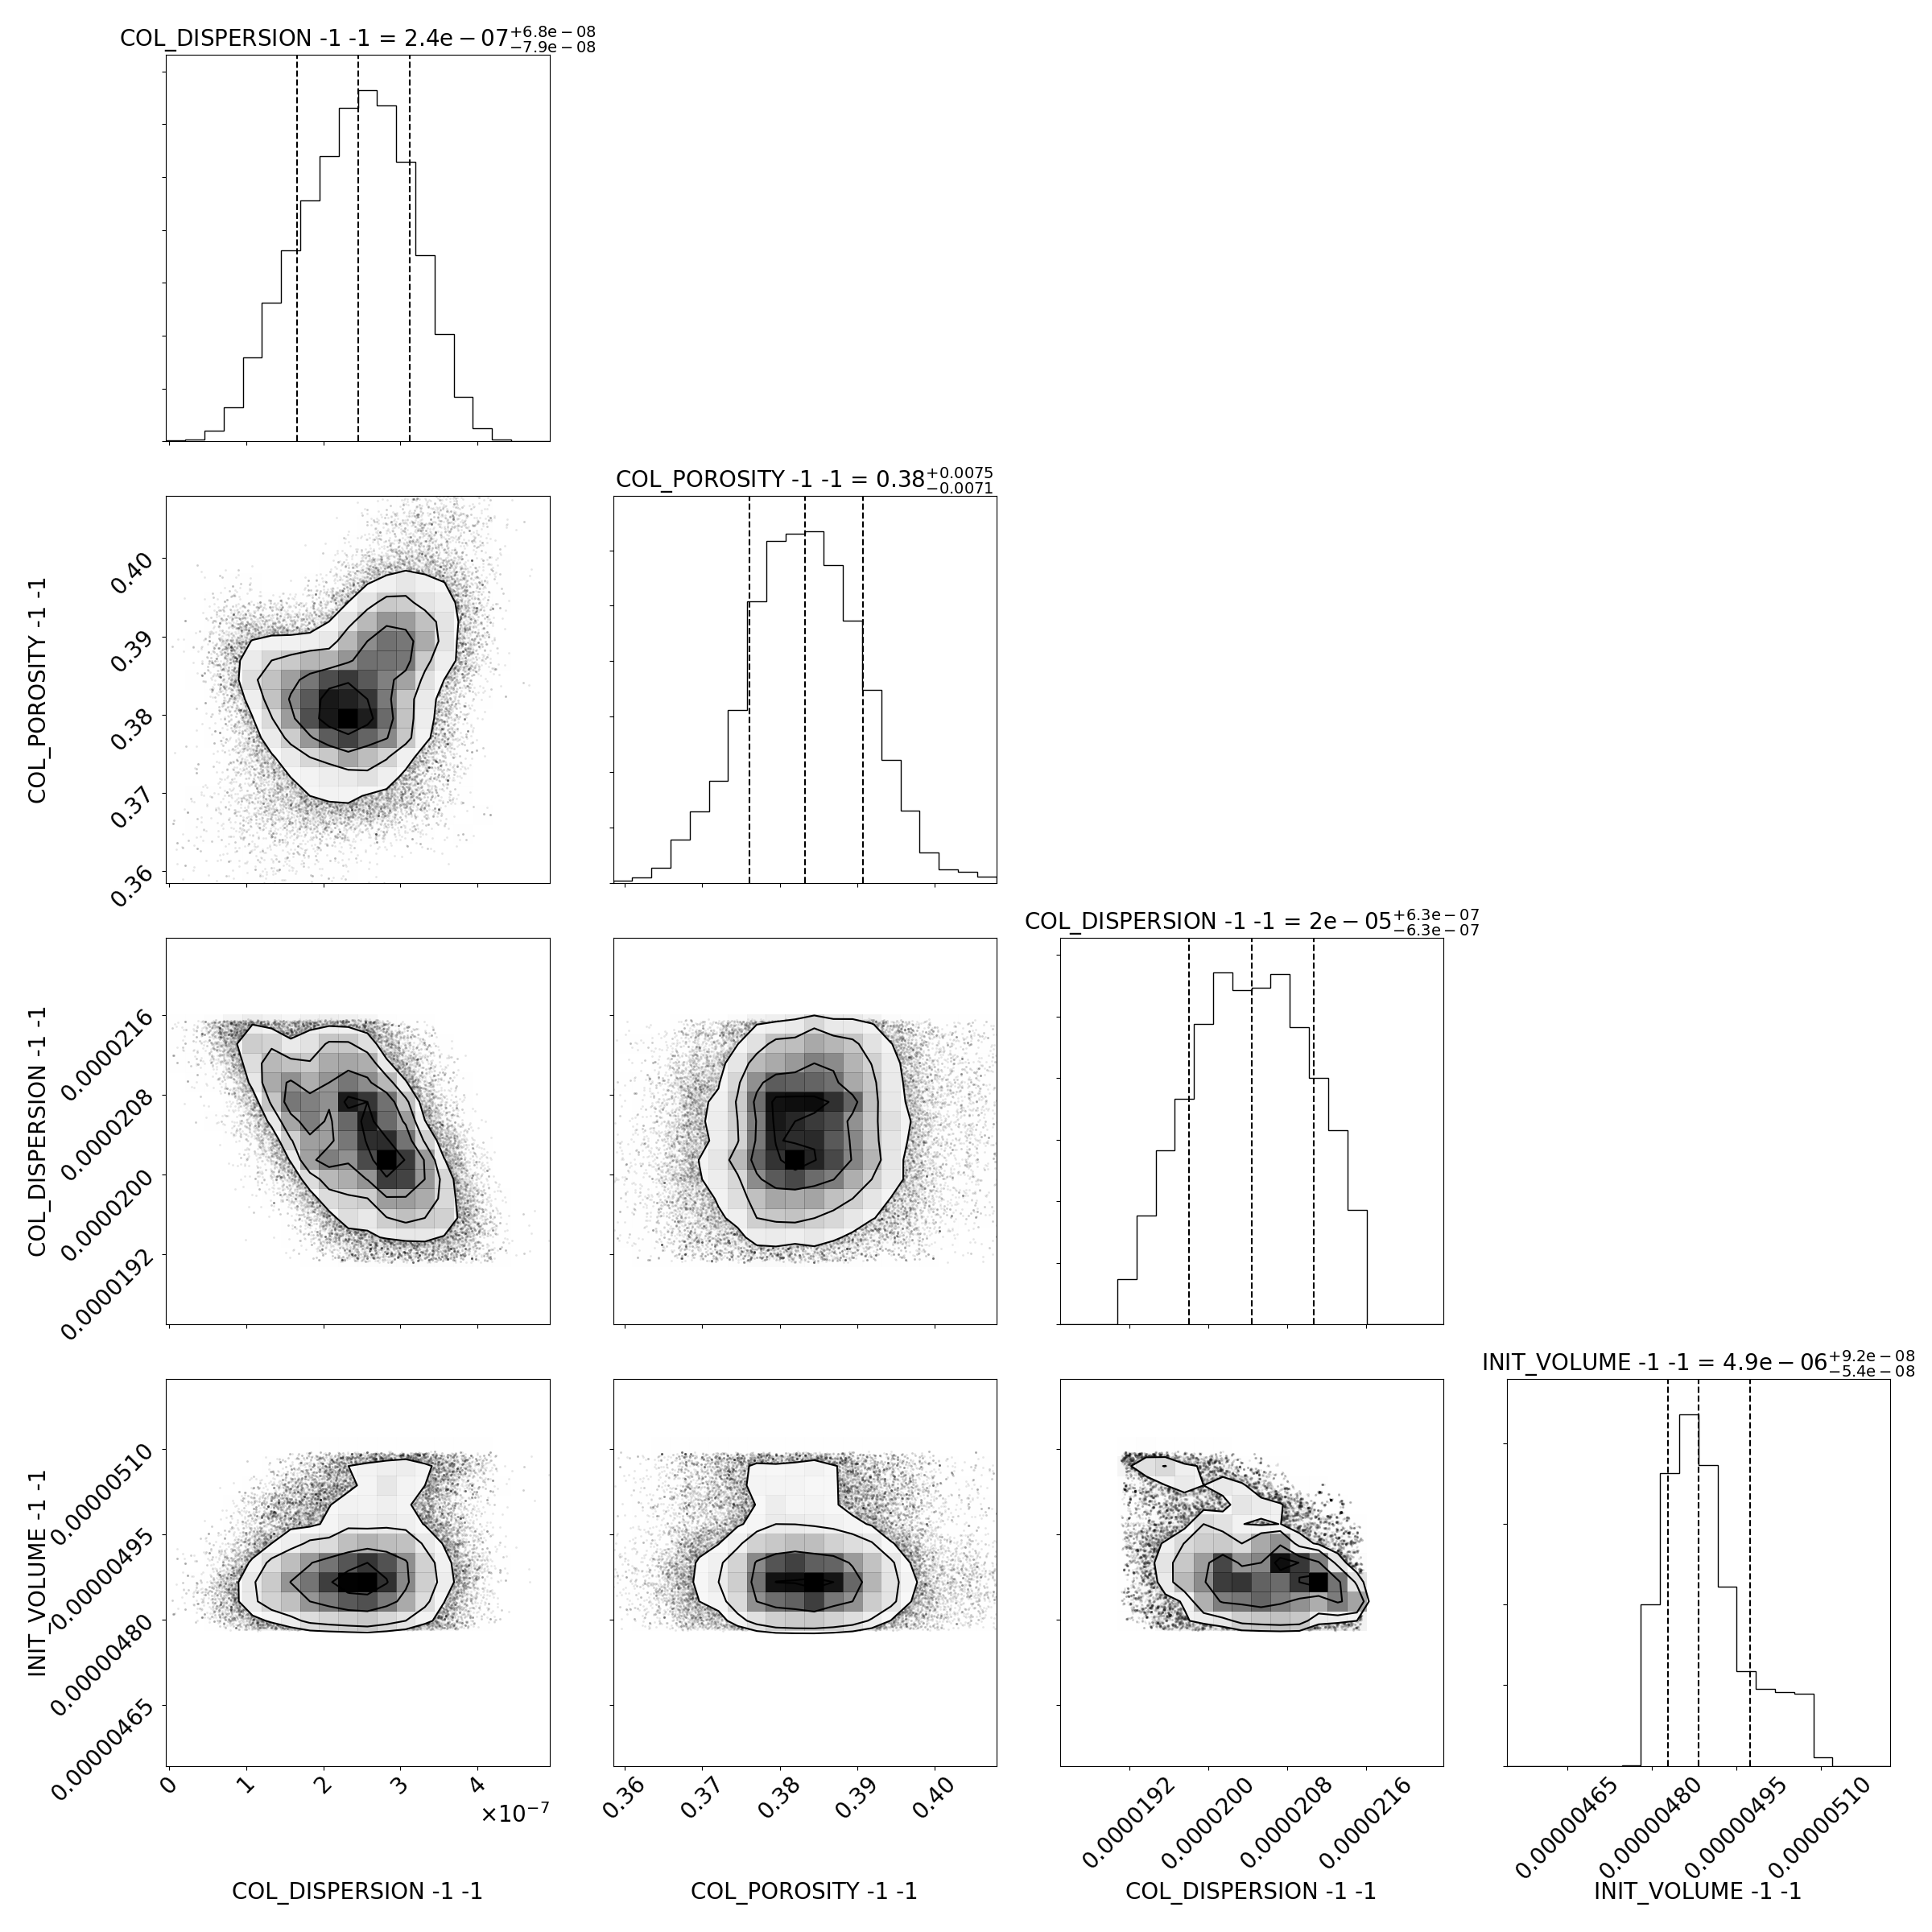

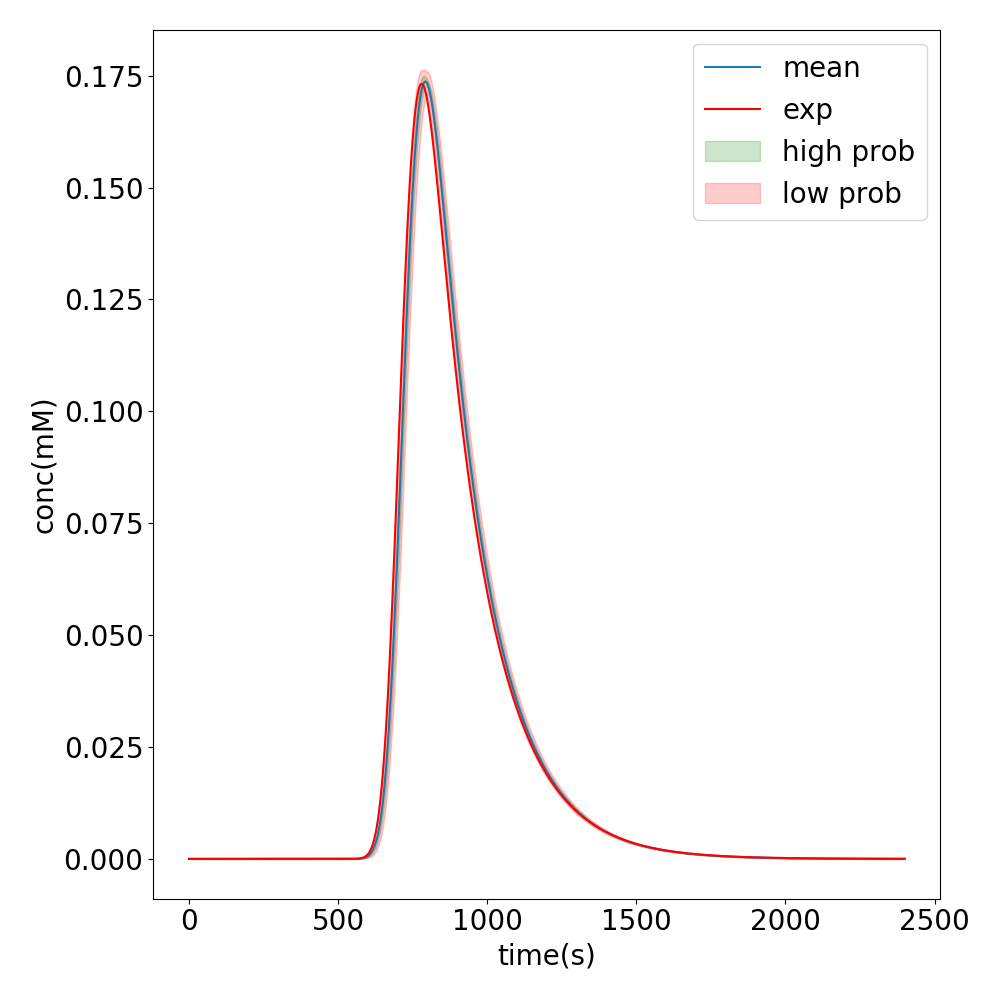

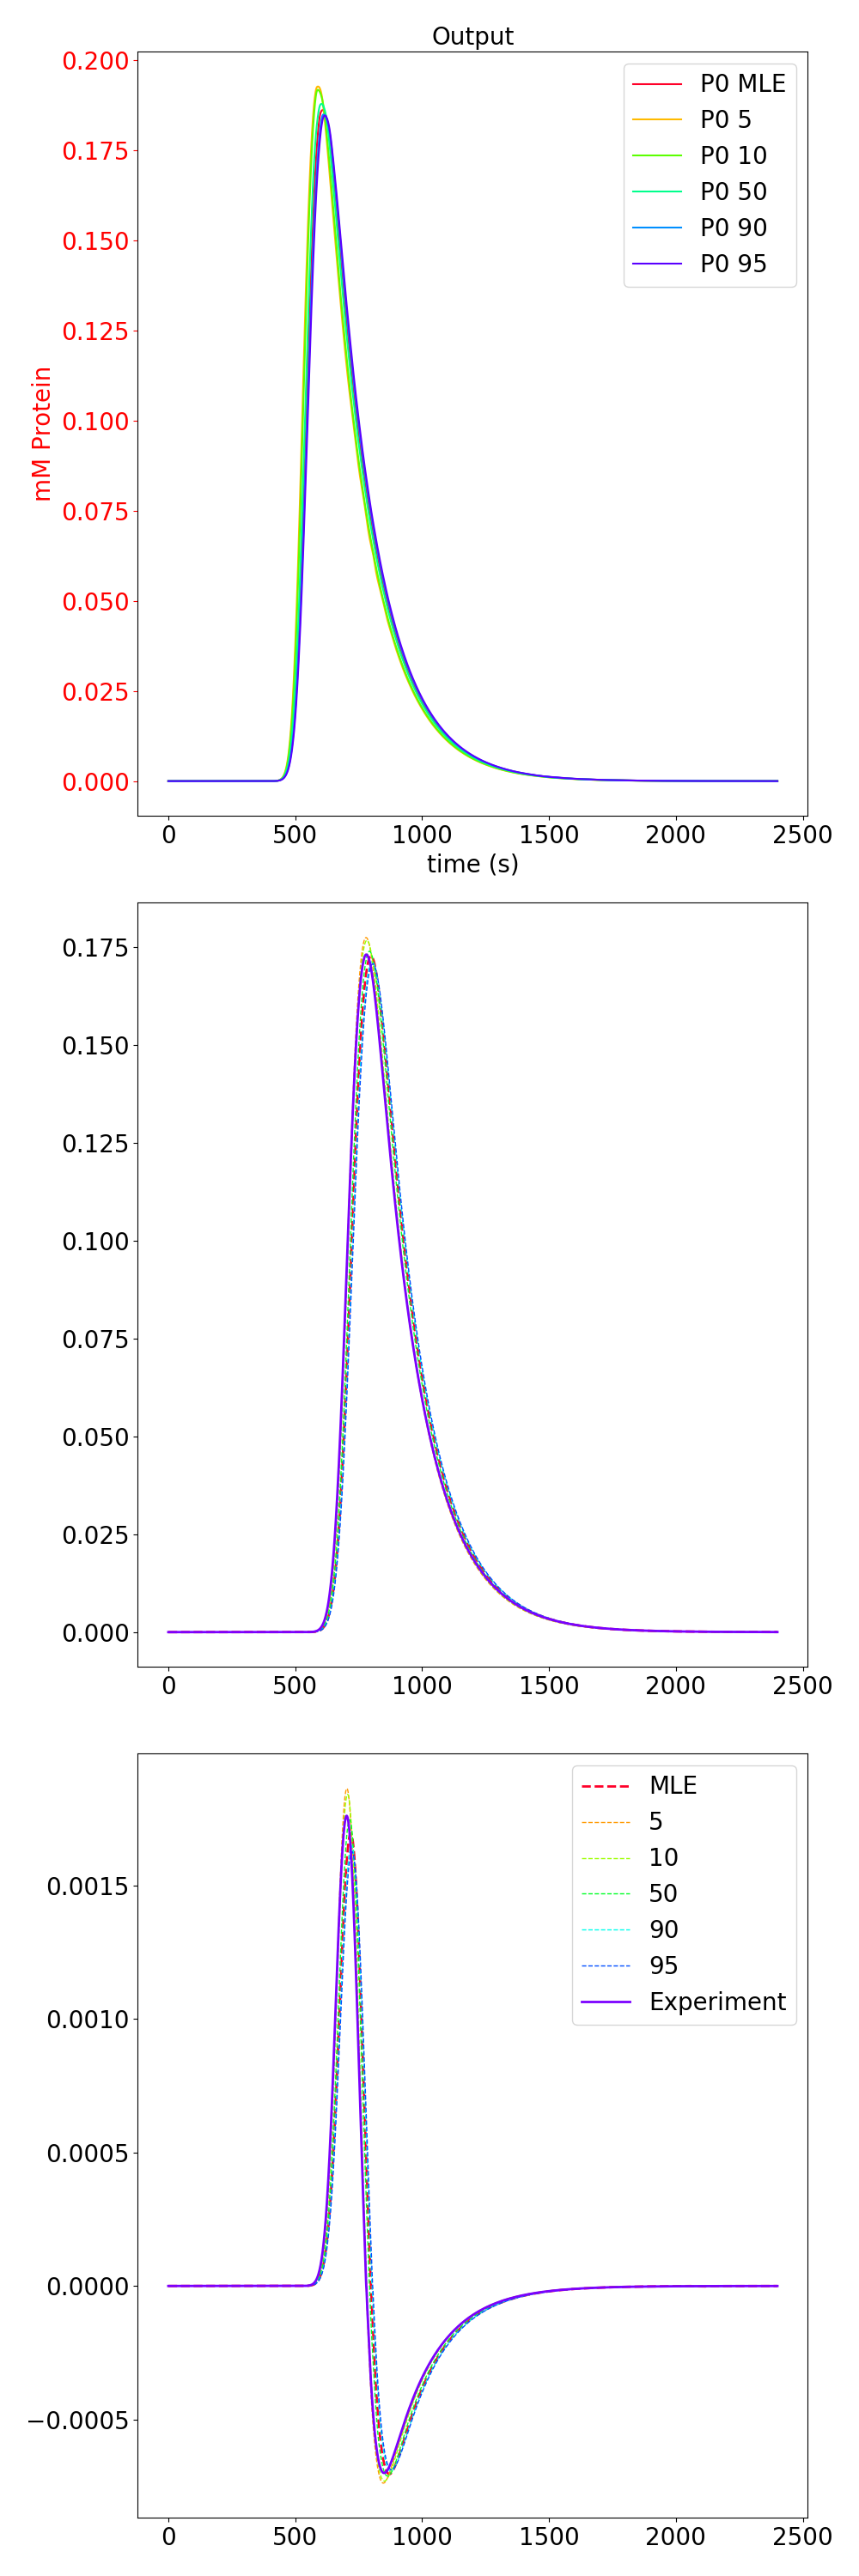

In [8]:
#look at the overall progress
display(Image( (example_dir_1 / match1.resultsDir / 'mcmc_refine' / 'progress' / 'tau_percent.png').as_posix(), width=800 ))

#look at burn in process
display(Image( (example_dir_1 / match1.resultsDir / 'mcmc_refine' / 'progress' / 'mcmc_acceptance.png').as_posix(), width=800 ))

#look at the acceptance
display(Image( (example_dir_1 / match1.resultsDir / 'mcmc_refine' / 'progress' / 'burn_in_acceptance.png').as_posix(), width=800 ))

#look at the distributions in search space
display(Image( (example_dir_1 / match1.resultsDir / 'mcmc_refine' / 'progress' / 'full_corner.png').as_posix(), width=800 ))

#look at the distributions in original space
display(Image( (example_dir_1 / match1.resultsDir / 'mcmc_refine' / 'progress' / 'full_corner_transform.png').as_posix(), width=800 ))

#look at output distribution
display(Image( (example_dir_1 / match1.resultsDir / 'mcmc_refine' / 'space' / 'mcmc' / 'main_unit_002_0.png').as_posix(), width=800 ))

#look at maximum likelihood
display(Image( (example_dir_1 / match1.resultsDir / 'mcmc_refine' / 'mcmc' / 'main_stats.png').as_posix(), width=800 ))

In [9]:
true_values1 = numpy.array([example1.root.input.model.unit_001.col_dispersion, 
                           example1.root.input.model.unit_001.col_porosity,
                            example1.root.input.model.unit_003.col_dispersion, 
                           example1.root.input.model.unit_005.init_volume,])

df = pandas.read_csv( (example_dir_1 / match1.resultsDir / 'mcmc_refine' / 'mcmc' / 'prob.csv').as_posix() )
display(df.style.format({'COL_DISPERSION Comp:-1 Bound:-1':"{:.2g}" , 'INIT_VOLUME Comp:-1 Bound:-1': "{:.2g}",
                        'COL_POROSITY Comp:-1 Bound:-1': "{:.2g}", 'COL_DISPERSION Comp:-1 Bound:-1.1': "{:.2g}"}))

print("Synthetic starting values")
print("Column dispersion %.2g" % true_values1[0])
print("Column porosity   %.2g" % true_values1[1])
print("Column dispersion %.2g" % true_values1[2])
print("CSTR volume       %.2g" % true_values1[3])

Synthetic starting values
Column dispersion 2e-07
Column porosity   0.37
Column dispersion 2e-05
CSTR volume       5e-06
